In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# from data_loading import sine_data_generation
# from utils import random_generator
# from data_loading import MinMaxScaler

from torch.utils.data import DataLoader


# from utils import extract_time


In [2]:
def train_test_divide (data_x, data_x_hat, data_t, data_t_hat, train_rate = 0.8):
  """ Divide train and test data for both original and synthetic data.
  
  Args:
    - data_x: original data
    - data_x_hat: generated data
    - data_t: original time
    - data_t_hat: generated time
    - train_rate: ratio of training data from the original data
  """
  # Divide train/test index (original data)
  no = len(data_x)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
    
  train_x = [data_x[i] for i in train_idx]
  test_x = [data_x[i] for i in test_idx]
  train_t = [data_t[i] for i in train_idx]
  test_t = [data_t[i] for i in test_idx]      
    
  # Divide train/test index (synthetic data)
  no = len(data_x_hat)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
  
  train_x_hat = [data_x_hat[i] for i in train_idx]
  test_x_hat = [data_x_hat[i] for i in test_idx]
  train_t_hat = [data_t_hat[i] for i in train_idx]
  test_t_hat = [data_t_hat[i] for i in test_idx]
  
  return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat


def extract_time (data):
  """Returns Maximum sequence length and each sequence length.
  
  Args:
    - data: original data
    
  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
  time = list()
  max_seq_len = 0
  for i in range(len(data)):
    max_seq_len = max(max_seq_len, len(data[i][:,0]))
    time.append(len(data[i][:,0]))
    
  return time, max_seq_len

def random_generator (batch_size, z_dim, T_mb, max_seq_len):
  """Random vector generation.
  
  Args:
    - batch_size: size of the random vector
    - z_dim: dimension of random vector
    - T_mb: time information for the random vector
    - max_seq_len: maximum sequence length
    
  Returns:
    - Z_mb: generated random vector
  """
  Z_mb = list()
  for i in range(batch_size):
    temp = np.zeros([max_seq_len, z_dim])
    temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
    temp[:T_mb[i],:] = temp_Z
    Z_mb.append(temp_Z)
  return Z_mb


def batch_generator(data, time, batch_size):
  """Mini-batch generator.
  
  Args:
    - data: time-series data
    - time: time information
    - batch_size: the number of samples in each batch
    
  Returns:
    - X_mb: time-series data in each batch
    - T_mb: time information in each batch
  """
  no = len(data)
  idx = np.random.permutation(no)
  train_idx = idx[:batch_size]     
            
  X_mb = list(data[i] for i in train_idx)
  T_mb = list(time[i] for i in train_idx)
  
  return X_mb, T_mb

In [3]:
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['stock','energy']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

Define Class for Module Construction

In [4]:
class Time_GAN_module(nn.Module):
    """
    Class from which a module of the Time GAN Architecture can be constructed, 
    consisting of a n_layer stacked RNN layers and a fully connected layer
    
    input_size = dim of data (depending if module operates on latent or non-latent space)
    """
    def __init__(self, input_size, output_size, hidden_dim, n_layers, activation=torch.sigmoid):
        super(Time_GAN_module, self).__init__()

        # Parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.sigma = activation

        #Defining the layers
        # RNN Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
    
            batch_size = x.size(0)

            # Initializing hidden state for first input using method defined below
            hidden = self.init_hidden(batch_size)

            # Passing in the input and hidden state into the model and obtaining outputs
            out, hidden = self.rnn(x, hidden)
        
            # Reshaping the outputs such that it can be fit into the fully connected layer
            out = out.contiguous().view(-1, self.hidden_dim)
            out = self.fc(out)
            
            if self.sigma == nn.Identity:
                idendity = nn.Identity()
                return idendity(out)
                
            out = self.sigma(out)
            
            # HIDDEN STATES WERDEN IN DER PAPER IMPLEMENTIERUNG AUCH COMPUTED, ALLERDINGS NICHT BENUTZT?
            
            return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

Parameters

In [5]:
input_size = 5 # sequence length = number of features
output_size = 20
hidden_dim = 20
n_layers = 3
gamma = 1

no, seq_len, dim = 12800, 24, 5 

batch_size = 128
epoch = 100

Data Generation

In [6]:
data = sine_data_generation(no, seq_len, dim)
data = MinMaxScaler(data)
data = torch.Tensor(data)
data.shape

torch.Size([12800, 24, 5])

Create Modules

In [24]:
# embedder: num_layers = num_layers, fully_connected dim = hidden_dim
# recovery: num_layers = num_layers, fully_connected dim = dim 
# generator: num layers = num_layers, fully_connected dim = hidden_dim
# supervisor: num_layers = num_layers-1, fully_connected dim = hidden_dim
# discriminator: num_layers = num_layers, fully_connected dim = 1

In [7]:
Embedder = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
Embedder

Time_GAN_module(
  (rnn): GRU(5, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [8]:
Recovery = Time_GAN_module(input_size=hidden_dim, output_size=dim, hidden_dim=hidden_dim, n_layers=n_layers)
Recovery

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=5, bias=True)
)

In [9]:
Generator = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
Generator

Time_GAN_module(
  (rnn): GRU(5, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [10]:
Supervisor = Time_GAN_module(input_size=hidden_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers-1)
Supervisor

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [11]:
Discriminator = Time_GAN_module(input_size=hidden_dim, output_size=1, hidden_dim=hidden_dim, n_layers=n_layers, 
                               activation=nn.Identity)
Discriminator

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Create Optimizers

In [12]:
embedder_optimizer = optim.Adam(Embedder.parameters(), lr=0.001)
recovery_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
supervisor_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(Discriminator.parameters(), lr=0.001)
generator_optimizer = optim.Adam(Generator.parameters(), lr=0.001)

Data Loader

In [13]:
loader = DataLoader(data, batch_size, shuffle=True)
X = next(iter(loader))
H, _ = Embedder(X.float())
H_re = torch.reshape(H, (batch_size, seq_len, hidden_dim))
H.shape, H_re.shape

(torch.Size([3072, 20]), torch.Size([128, 24, 20]))

In [14]:
batch_size, seq_len, hidden_dim

(128, 24, 20)

In [36]:
random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])

In [37]:
loader = DataLoader(data, batch_size, shuffle=True)

random_loader = DataLoader(random_data, batch_size, shuffle=True)

binary_cross_entropy_loss = nn.BCEWithLogitsLoss()

MSE_loss = nn.MSELoss()



In [38]:
X = next(iter(loader))
X.shape

torch.Size([128, 24, 5])

In [127]:
def TimeGAN(data, parameters):
  hidden_dim = parameters["hidden_dim"]
  num_layers = parameters["num_layers"]
  iterations = parameters["iterations"]
  batch_size = parameters["batch_size"]
  module = parameters["module"]
  epoch = parameters["epoch"]
  no, seq_len, dim = np.asarray(data).shape
  z_dim = dim
  gamma = 1

  Embedder = Time_GAN_module(input_size=z_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=num_layers)
  Recovery = Time_GAN_module(input_size=hidden_dim, output_size=dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Generator = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Supervisor = Time_GAN_module(input_size=hidden_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers-1)
  Discriminator = Time_GAN_module(input_size=hidden_dim, output_size=1, hidden_dim=hidden_dim, n_layers=n_layers, activation=nn.Identity)

  embedder_optimizer = optim.Adam(Embedder.parameters(), lr=0.001)
  recovery_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
  supervisor_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
  discriminator_optimizer = optim.Adam(Discriminator.parameters(), lr=0.001)
  generator_optimizer = optim.Adam(Generator.parameters(), lr=0.001)

  # Embedding Network Training
  print('Start Embedding Network Training')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):
        
        MSE_loss = nn.MSELoss()
        
        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        X_tilde, _ = Recovery(H)
        X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

        E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  

        Embedder.zero_grad()
        Recovery.zero_grad()

        E_loss0.backward(retain_graph=True)

        embedder_optimizer.step()
        recovery_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', e_loss: ' + str(np.sqrt(E_loss0.detach().numpy())))

  print('Finish Embedding Network Training')

  # Training only with supervised loss
  print('Start Training with Supervised Loss Only')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):

        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        H_hat_supervise, _ = Supervisor(H)
        H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

        G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])


        Embedder.zero_grad()
        Supervisor.zero_grad()

        G_loss_S.backward(retain_graph=True)

        embedder_optimizer.step()
        supervisor_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', s_loss: ' + str(np.sqrt(G_loss_S.detach().numpy())))

  print('Finish Training with Supervised Loss Only')
  # Joint Training
  

  print('Start Joint Training')
  for itt in range(epoch):
    for kk in range(2):
      X = next(iter(loader))
      random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
        
      # Generator Training 
      ## Train Generator
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()

      # line 267 of original implementation: 
      # G_loss_U, G_loss_S, G_loss_V
      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      G_loss_U = binary_cross_entropy_loss(torch.ones_like(Y_fake), Y_fake)
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#


      generator_optimizer.step()
      supervisor_optimizer.step()
      discriminator_optimizer.step()
      # Train Embedder 
      ## line 270: we only optimize E_loss_T0
      ## E_loss_T0 = just mse of x and x_tilde
      # but it calls E_solver which optimizes E_loss, which is a sum of 
      # E_loss0 and 0.1* G_loss_S
      MSE_loss = nn.MSELoss()
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
        
      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      G_loss_S.backward(retain_graph=True)
      E_loss_T0.backward()
        
      Embedder.zero_grad()
      Recovery.zero_grad()
      Supervisor.zero_grad()
        
      embedder_optimizer.step()
      recovery_optimizer.step()
      supervisor_optimizer.step()
    # train Discriminator
    for batch_index, X in enumerate(loader):
      random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
      
      z = torch.tensor(random_data)
      z = z.float()

      H, _ = Embedder(X)
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      Y_real = Discriminator(H)
      Y_real = torch.reshape(Y_real, (batch_size, seq_len, 1))
      
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))

      Y_fake_e = Discriminator(e_hat)
      Y_fake_e = torch.reshape(Y_fake_e, (batch_size, seq_len, 1))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()
      Embedder.zero_grad()

      # logits first, then targets
      # D_loss_real(Y_real, torch.ones_like(Y_real))
      D_loss_real = nn.BCEWithLogitsLoss()
      DLR = D_loss_real(Y_real, torch.ones_like(Y_real))

      D_loss_fake = nn.BCEWithLogitsLoss()
      DLF = D_loss_fake(Y_fake, torch.zeros_like(Y_fake))

      D_loss_fake_e = nn.BCEWithLogitsLoss()
      DLF_e = D_loss_fake_e(Y_fake_e, torch.zeros_like(Y_fake_e))

      D_loss = DLR + DLF + gamma * DLF_e

      # D_loss.backward(retain_graph=True)
      
      # discriminator_optimizer.step()

      # check discriminator loss before updating
      check_d_loss = D_loss
      if (check_d_loss > 0.15):
        D_loss.backward(retain_graph=True)
        discriminator_optimizer.step()        
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim)) 
        
      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      G_loss_U = binary_cross_entropy_loss(torch.ones_like(Y_fake), Y_fake)
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
    
      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#
      E_loss.backward()

      generator_optimizer.step()
      supervisor_optimizer.step()
      #discriminator_optimizer.step() 
      embedder_optimizer.step()
      recovery_optimizer.step()
            
      print('step: '+ str(itt) + '/' + str(epoch) + 
            ', D_loss: ' + str(D_loss.detach().numpy()) +
            ', G_loss_U: ' + str(G_loss_U.detach().numpy()) + 
            ', G_loss_S: ' + str(G_loss_S.detach().numpy()) + 
            ', E_loss_t0: ' + str(np.sqrt(E_loss0.detach().numpy()))
             )
  print('Finish Joint Training')

In [128]:
parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layers'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128
parameters['epoch'] = 50

In [129]:
TimeGAN(data, parameters)

Start Embedding Network Training
step: 1/50, e_loss: 1.6149828
step: 2/50, e_loss: 1.5064645
step: 3/50, e_loss: 1.4697814
step: 4/50, e_loss: 1.4237516
step: 5/50, e_loss: 1.3381127
step: 6/50, e_loss: 1.3051033
step: 7/50, e_loss: 1.2860656
step: 8/50, e_loss: 1.1078863
step: 9/50, e_loss: 1.0635854
step: 10/50, e_loss: 0.9845366
step: 11/50, e_loss: 0.7573251
step: 12/50, e_loss: 0.6505333
step: 13/50, e_loss: 0.5831463
step: 14/50, e_loss: 0.54910254
step: 15/50, e_loss: 0.5291148
step: 16/50, e_loss: 0.5005566
step: 17/50, e_loss: 0.4828723
step: 18/50, e_loss: 0.48521358
step: 19/50, e_loss: 0.46938503
step: 20/50, e_loss: 0.4582306
step: 21/50, e_loss: 0.43810058
step: 22/50, e_loss: 0.42440876
step: 23/50, e_loss: 0.41973054
step: 24/50, e_loss: 0.41862756
step: 25/50, e_loss: 0.40386507
step: 26/50, e_loss: 0.41072008
step: 27/50, e_loss: 0.40251216
step: 28/50, e_loss: 0.40172195
step: 29/50, e_loss: 0.39030847
step: 30/50, e_loss: 0.38272506
step: 31/50, e_loss: 0.38412166
s

step: 0/50, D_loss: 0.802387, G_loss_U: 2.802125, G_loss_S: 0.08424535, E_loss_t0: 2.504763
step: 0/50, D_loss: 0.73988616, G_loss_U: 2.9765205, G_loss_S: 0.08737646, E_loss_t0: 2.5164044
step: 0/50, D_loss: 0.68643826, G_loss_U: 3.1311095, G_loss_S: 0.08977575, E_loss_t0: 2.4952457
step: 0/50, D_loss: 0.6394011, G_loss_U: 3.2641537, G_loss_S: 0.09211752, E_loss_t0: 2.5200634
step: 0/50, D_loss: 0.6012719, G_loss_U: 3.3777199, G_loss_S: 0.09374053, E_loss_t0: 2.5035868
step: 0/50, D_loss: 0.5663819, G_loss_U: 3.4752045, G_loss_S: 0.09502123, E_loss_t0: 2.4927137
step: 0/50, D_loss: 0.5343473, G_loss_U: 3.5600252, G_loss_S: 0.09609457, E_loss_t0: 2.5020087
step: 0/50, D_loss: 0.50588334, G_loss_U: 3.6348493, G_loss_S: 0.09687247, E_loss_t0: 2.502464
step: 0/50, D_loss: 0.48153257, G_loss_U: 3.7017422, G_loss_S: 0.097207114, E_loss_t0: 2.5178137
step: 0/50, D_loss: 0.45639953, G_loss_U: 3.7623103, G_loss_S: 0.097663134, E_loss_t0: 2.5061898
step: 0/50, D_loss: 0.43171042, G_loss_U: 3.817

step: 1/50, D_loss: 0.14926709, G_loss_U: 4.7949233, G_loss_S: 0.034861363, E_loss_t0: 2.5187333
step: 1/50, D_loss: 0.14948219, G_loss_U: 4.794728, G_loss_S: 0.034047723, E_loss_t0: 2.4992962
step: 1/50, D_loss: 0.15050592, G_loss_U: 4.810063, G_loss_S: 0.033184156, E_loss_t0: 2.4999406
step: 1/50, D_loss: 0.14894618, G_loss_U: 4.8098817, G_loss_S: 0.032355923, E_loss_t0: 2.5123718
step: 1/50, D_loss: 0.1490322, G_loss_U: 4.809761, G_loss_S: 0.03151745, E_loss_t0: 2.4951658
step: 1/50, D_loss: 0.14992544, G_loss_U: 4.8096213, G_loss_S: 0.030677477, E_loss_t0: 2.5160227
step: 1/50, D_loss: 0.1501015, G_loss_U: 4.8246493, G_loss_S: 0.029843144, E_loss_t0: 2.5253274
step: 1/50, D_loss: 0.14944302, G_loss_U: 4.824576, G_loss_S: 0.029055713, E_loss_t0: 2.519733
step: 1/50, D_loss: 0.14941663, G_loss_U: 4.824427, G_loss_S: 0.028237972, E_loss_t0: 2.5113568
step: 1/50, D_loss: 0.15027663, G_loss_U: 4.8389826, G_loss_S: 0.027463546, E_loss_t0: 2.5067015
step: 1/50, D_loss: 0.14877231, G_loss_

step: 2/50, D_loss: 0.1517524, G_loss_U: 4.617705, G_loss_S: 0.012584308, E_loss_t0: 2.5308733
step: 2/50, D_loss: 0.15494916, G_loss_U: 4.254406, G_loss_S: 0.0124487635, E_loss_t0: 2.5189593
step: 2/50, D_loss: 0.16802917, G_loss_U: 4.604404, G_loss_S: 0.012303374, E_loss_t0: 2.5286665
step: 2/50, D_loss: 0.15477255, G_loss_U: 4.692717, G_loss_S: 0.012177266, E_loss_t0: 2.5335453
step: 2/50, D_loss: 0.1506529, G_loss_U: 4.7377295, G_loss_S: 0.012092918, E_loss_t0: 2.524262
step: 2/50, D_loss: 0.14845209, G_loss_U: 4.737536, G_loss_S: 0.012033161, E_loss_t0: 2.5234523
step: 2/50, D_loss: 0.14791462, G_loss_U: 4.737347, G_loss_S: 0.011984699, E_loss_t0: 2.5173104
step: 2/50, D_loss: 0.14713265, G_loss_U: 4.737196, G_loss_S: 0.011893571, E_loss_t0: 2.5134954
step: 2/50, D_loss: 0.14608154, G_loss_U: 4.737026, G_loss_S: 0.011797993, E_loss_t0: 2.498402
step: 2/50, D_loss: 0.14632113, G_loss_U: 4.7369065, G_loss_S: 0.011671293, E_loss_t0: 2.5115826
step: 2/50, D_loss: 0.14637548, G_loss_U:

step: 3/50, D_loss: 0.14272039, G_loss_U: 4.654375, G_loss_S: 0.013564847, E_loss_t0: 2.482788
step: 3/50, D_loss: 0.14270177, G_loss_U: 4.654344, G_loss_S: 0.013330515, E_loss_t0: 2.5265539
step: 3/50, D_loss: 0.14238007, G_loss_U: 4.6543093, G_loss_S: 0.013079304, E_loss_t0: 2.529287
step: 3/50, D_loss: 0.14271067, G_loss_U: 4.6542606, G_loss_S: 0.0127617065, E_loss_t0: 2.5106194
step: 3/50, D_loss: 0.14281541, G_loss_U: 4.654223, G_loss_S: 0.012382093, E_loss_t0: 2.521893
step: 3/50, D_loss: 0.14297181, G_loss_U: 4.6541905, G_loss_S: 0.011972485, E_loss_t0: 2.4975958
step: 3/50, D_loss: 0.14296535, G_loss_U: 4.6541476, G_loss_S: 0.011522307, E_loss_t0: 2.507817
step: 3/50, D_loss: 0.14308362, G_loss_U: 4.654101, G_loss_S: 0.011084643, E_loss_t0: 2.490599
step: 3/50, D_loss: 0.14334999, G_loss_U: 4.654055, G_loss_S: 0.01059887, E_loss_t0: 2.5183039
step: 3/50, D_loss: 0.14309897, G_loss_U: 4.654016, G_loss_S: 0.010128337, E_loss_t0: 2.5054314
step: 3/50, D_loss: 0.14375575, G_loss_U:

step: 3/50, D_loss: 0.13493726, G_loss_U: 4.69426, G_loss_S: 0.042795263, E_loss_t0: 2.5016618
step: 3/50, D_loss: 0.13496256, G_loss_U: 4.694258, G_loss_S: 0.04245378, E_loss_t0: 2.4914358
step: 3/50, D_loss: 0.13496645, G_loss_U: 4.694259, G_loss_S: 0.04228597, E_loss_t0: 2.4727857
step: 3/50, D_loss: 0.13500309, G_loss_U: 4.694255, G_loss_S: 0.04167678, E_loss_t0: 2.516047
step: 3/50, D_loss: 0.13502719, G_loss_U: 4.694253, G_loss_S: 0.041458413, E_loss_t0: 2.5027993
step: 4/50, D_loss: 0.13984692, G_loss_U: 4.643295, G_loss_S: 0.040507197, E_loss_t0: 2.5259483
step: 4/50, D_loss: 0.13981664, G_loss_U: 4.6432934, G_loss_S: 0.04020902, E_loss_t0: 2.509001
step: 4/50, D_loss: 0.1397655, G_loss_U: 4.6432905, G_loss_S: 0.03985908, E_loss_t0: 2.5225434
step: 4/50, D_loss: 0.13978656, G_loss_U: 4.643289, G_loss_S: 0.03960465, E_loss_t0: 2.519163
step: 4/50, D_loss: 0.13985881, G_loss_U: 4.643287, G_loss_S: 0.039370794, E_loss_t0: 2.5206735
step: 4/50, D_loss: 0.1397689, G_loss_U: 4.643285

step: 4/50, D_loss: 0.14050177, G_loss_U: 4.643162, G_loss_S: 0.026750105, E_loss_t0: 2.494938
step: 4/50, D_loss: 0.14049047, G_loss_U: 4.6431594, G_loss_S: 0.026648453, E_loss_t0: 2.5120118
step: 4/50, D_loss: 0.14057021, G_loss_U: 4.6431575, G_loss_S: 0.026528584, E_loss_t0: 2.5105147
step: 4/50, D_loss: 0.14049189, G_loss_U: 4.643155, G_loss_S: 0.026443899, E_loss_t0: 2.4987886
step: 4/50, D_loss: 0.14063388, G_loss_U: 4.643155, G_loss_S: 0.02634513, E_loss_t0: 2.4975111
step: 4/50, D_loss: 0.14061439, G_loss_U: 4.643152, G_loss_S: 0.026230844, E_loss_t0: 2.5226068
step: 4/50, D_loss: 0.14061953, G_loss_U: 4.643151, G_loss_S: 0.026172189, E_loss_t0: 2.5049262
step: 4/50, D_loss: 0.14062677, G_loss_U: 4.6431484, G_loss_S: 0.026045099, E_loss_t0: 2.5222073
step: 4/50, D_loss: 0.14064273, G_loss_U: 4.6431456, G_loss_S: 0.025967805, E_loss_t0: 2.4986508
step: 4/50, D_loss: 0.1406604, G_loss_U: 4.643144, G_loss_S: 0.025848657, E_loss_t0: 2.5105534
step: 4/50, D_loss: 0.14066815, G_loss_

step: 5/50, D_loss: 0.14968725, G_loss_U: 4.5566626, G_loss_S: 0.019483833, E_loss_t0: 2.4873292
step: 5/50, D_loss: 0.14989926, G_loss_U: 4.556661, G_loss_S: 0.01942192, E_loss_t0: 2.4950747
step: 5/50, D_loss: 0.14982912, G_loss_U: 4.5566583, G_loss_S: 0.019329866, E_loss_t0: 2.5100944
step: 5/50, D_loss: 0.14993966, G_loss_U: 4.5566545, G_loss_S: 0.019275662, E_loss_t0: 2.5021873
step: 5/50, D_loss: 0.14981908, G_loss_U: 4.5566525, G_loss_S: 0.01920184, E_loss_t0: 2.5178475
step: 5/50, D_loss: 0.14995746, G_loss_U: 4.5566506, G_loss_S: 0.01914902, E_loss_t0: 2.4780653
step: 5/50, D_loss: 0.14987801, G_loss_U: 4.5566487, G_loss_S: 0.019058945, E_loss_t0: 2.5111394
step: 5/50, D_loss: 0.14977026, G_loss_U: 4.5566454, G_loss_S: 0.019004691, E_loss_t0: 2.5017438
step: 5/50, D_loss: 0.14991117, G_loss_U: 4.556642, G_loss_S: 0.018956143, E_loss_t0: 2.4949038
step: 5/50, D_loss: 0.14993659, G_loss_U: 4.556641, G_loss_S: 0.01887308, E_loss_t0: 2.5064683
step: 5/50, D_loss: 0.14990436, G_los

step: 6/50, D_loss: 0.14874661, G_loss_U: 4.4988837, G_loss_S: 0.014714144, E_loss_t0: 2.4906745
step: 6/50, D_loss: 0.14884949, G_loss_U: 4.498882, G_loss_S: 0.014704922, E_loss_t0: 2.4738722
step: 6/50, D_loss: 0.14874965, G_loss_U: 4.498879, G_loss_S: 0.014628697, E_loss_t0: 2.4794517
step: 6/50, D_loss: 0.14882089, G_loss_U: 4.498877, G_loss_S: 0.014572686, E_loss_t0: 2.479795
step: 6/50, D_loss: 0.14887029, G_loss_U: 4.498875, G_loss_S: 0.014544998, E_loss_t0: 2.45148
step: 6/50, D_loss: 0.14879814, G_loss_U: 4.4988728, G_loss_S: 0.0144871455, E_loss_t0: 2.4783065
step: 6/50, D_loss: 0.14887775, G_loss_U: 4.4988694, G_loss_S: 0.01443157, E_loss_t0: 2.4812393
step: 6/50, D_loss: 0.14884421, G_loss_U: 4.4988675, G_loss_S: 0.014388007, E_loss_t0: 2.468182
step: 6/50, D_loss: 0.14884233, G_loss_U: 4.4988656, G_loss_S: 0.014329581, E_loss_t0: 2.4689684
step: 6/50, D_loss: 0.14891441, G_loss_U: 4.4988637, G_loss_S: 0.014276039, E_loss_t0: 2.4857812
step: 6/50, D_loss: 0.14887898, G_loss

step: 7/50, D_loss: 0.14941041, G_loss_U: 4.4776063, G_loss_S: 0.011029952, E_loss_t0: 2.4888663
step: 7/50, D_loss: 0.14931309, G_loss_U: 4.4776034, G_loss_S: 0.010979568, E_loss_t0: 2.5039344
step: 7/50, D_loss: 0.14939277, G_loss_U: 4.4776015, G_loss_S: 0.010958079, E_loss_t0: 2.4508557
step: 7/50, D_loss: 0.14926322, G_loss_U: 4.477599, G_loss_S: 0.010897996, E_loss_t0: 2.4869983
step: 7/50, D_loss: 0.14941737, G_loss_U: 4.4775977, G_loss_S: 0.010880214, E_loss_t0: 2.470569
step: 7/50, D_loss: 0.14928055, G_loss_U: 4.4775968, G_loss_S: 0.01083164, E_loss_t0: 2.4794352
step: 7/50, D_loss: 0.14942124, G_loss_U: 4.477594, G_loss_S: 0.010813705, E_loss_t0: 2.4708095
step: 7/50, D_loss: 0.14939596, G_loss_U: 4.4775915, G_loss_S: 0.010764435, E_loss_t0: 2.482055
step: 7/50, D_loss: 0.1493945, G_loss_U: 4.4775896, G_loss_S: 0.010729353, E_loss_t0: 2.4815536
step: 7/50, D_loss: 0.14937991, G_loss_U: 4.477588, G_loss_S: 0.010687336, E_loss_t0: 2.4831078
step: 7/50, D_loss: 0.14949611, G_los

step: 8/50, D_loss: 0.14949615, G_loss_U: 4.4540973, G_loss_S: 0.008279427, E_loss_t0: 2.4781406
step: 8/50, D_loss: 0.14940229, G_loss_U: 4.4540963, G_loss_S: 0.008260024, E_loss_t0: 2.4821677
step: 8/50, D_loss: 0.14949928, G_loss_U: 4.454096, G_loss_S: 0.008238588, E_loss_t0: 2.4615343
step: 8/50, D_loss: 0.14941324, G_loss_U: 4.4540944, G_loss_S: 0.008191675, E_loss_t0: 2.499553
step: 8/50, D_loss: 0.14945228, G_loss_U: 4.4540935, G_loss_S: 0.0081839925, E_loss_t0: 2.4823601
step: 8/50, D_loss: 0.14947042, G_loss_U: 4.4540915, G_loss_S: 0.008154591, E_loss_t0: 2.4812262
step: 8/50, D_loss: 0.14941956, G_loss_U: 4.4540906, G_loss_S: 0.008109582, E_loss_t0: 2.4951735
step: 8/50, D_loss: 0.14955519, G_loss_U: 4.4540887, G_loss_S: 0.008094814, E_loss_t0: 2.4917114
step: 8/50, D_loss: 0.14954309, G_loss_U: 4.454088, G_loss_S: 0.008079854, E_loss_t0: 2.4600327
step: 8/50, D_loss: 0.14955434, G_loss_U: 4.4540863, G_loss_S: 0.008057676, E_loss_t0: 2.4647574
step: 8/50, D_loss: 0.14945722, 

step: 9/50, D_loss: 0.15382144, G_loss_U: 4.4061046, G_loss_S: 0.0063244696, E_loss_t0: 2.4798238
step: 9/50, D_loss: 0.15312347, G_loss_U: 4.4117055, G_loss_S: 0.0063224924, E_loss_t0: 2.467066
step: 9/50, D_loss: 0.15228015, G_loss_U: 4.4182115, G_loss_S: 0.006287333, E_loss_t0: 2.496903
step: 9/50, D_loss: 0.1515161, G_loss_U: 4.425525, G_loss_S: 0.006271966, E_loss_t0: 2.4982088
step: 9/50, D_loss: 0.15050784, G_loss_U: 4.433555, G_loss_S: 0.00626131, E_loss_t0: 2.4714248
step: 9/50, D_loss: 0.14948136, G_loss_U: 4.4335546, G_loss_S: 0.0062482227, E_loss_t0: 2.4703398
step: 9/50, D_loss: 0.14956613, G_loss_U: 4.433553, G_loss_S: 0.0062343627, E_loss_t0: 2.4719694
step: 9/50, D_loss: 0.1496133, G_loss_U: 4.4335546, G_loss_S: 0.006231919, E_loss_t0: 2.4640176
step: 9/50, D_loss: 0.14949702, G_loss_U: 4.433554, G_loss_S: 0.006198016, E_loss_t0: 2.4852984
step: 9/50, D_loss: 0.14943641, G_loss_U: 4.4335537, G_loss_S: 0.0061847265, E_loss_t0: 2.4760015
step: 9/50, D_loss: 0.14957339, G_

step: 9/50, D_loss: 0.14886126, G_loss_U: 4.4421325, G_loss_S: 0.0049139257, E_loss_t0: 2.4906304
step: 9/50, D_loss: 0.14884269, G_loss_U: 4.4421315, G_loss_S: 0.0048995703, E_loss_t0: 2.4603639
step: 9/50, D_loss: 0.14892223, G_loss_U: 4.4421306, G_loss_S: 0.0048899367, E_loss_t0: 2.4823542
step: 9/50, D_loss: 0.14898095, G_loss_U: 4.4421296, G_loss_S: 0.004882949, E_loss_t0: 2.4602785
step: 9/50, D_loss: 0.14893767, G_loss_U: 4.4421277, G_loss_S: 0.004861431, E_loss_t0: 2.4599664
step: 10/50, D_loss: 0.15119344, G_loss_U: 4.403329, G_loss_S: 0.004813185, E_loss_t0: 2.4779155
step: 10/50, D_loss: 0.15274449, G_loss_U: 4.3911786, G_loss_S: 0.004803933, E_loss_t0: 2.4835215
step: 10/50, D_loss: 0.15378389, G_loss_U: 4.381641, G_loss_S: 0.004785475, E_loss_t0: 2.4994757
step: 10/50, D_loss: 0.15480654, G_loss_U: 4.3744907, G_loss_S: 0.00478103, E_loss_t0: 2.4770072
step: 10/50, D_loss: 0.15531534, G_loss_U: 4.369517, G_loss_S: 0.004766774, E_loss_t0: 2.4571323
step: 10/50, D_loss: 0.155

step: 10/50, D_loss: 0.14993425, G_loss_U: 4.411217, G_loss_S: 0.0038264112, E_loss_t0: 2.4788105
step: 10/50, D_loss: 0.14985745, G_loss_U: 4.4112163, G_loss_S: 0.0038084015, E_loss_t0: 2.477762
step: 10/50, D_loss: 0.14990568, G_loss_U: 4.4112163, G_loss_S: 0.003800226, E_loss_t0: 2.4697235
step: 10/50, D_loss: 0.14992839, G_loss_U: 4.4112144, G_loss_S: 0.0037837503, E_loss_t0: 2.4645498
step: 10/50, D_loss: 0.14989044, G_loss_U: 4.4112134, G_loss_S: 0.0037799599, E_loss_t0: 2.4668856
step: 10/50, D_loss: 0.14998806, G_loss_U: 4.4112124, G_loss_S: 0.003767262, E_loss_t0: 2.4908748
step: 10/50, D_loss: 0.15000477, G_loss_U: 4.4205146, G_loss_S: 0.0037595094, E_loss_t0: 2.4768796
step: 10/50, D_loss: 0.1488588, G_loss_U: 4.4205136, G_loss_S: 0.0037399228, E_loss_t0: 2.4856446
step: 10/50, D_loss: 0.1488511, G_loss_U: 4.4205127, G_loss_S: 0.003727661, E_loss_t0: 2.4757457
step: 10/50, D_loss: 0.14872602, G_loss_U: 4.4205127, G_loss_S: 0.0037160127, E_loss_t0: 2.450092
step: 10/50, D_los

step: 11/50, D_loss: 0.14937097, G_loss_U: 4.393452, G_loss_S: 0.0029777181, E_loss_t0: 2.4858198
step: 11/50, D_loss: 0.14936525, G_loss_U: 4.393451, G_loss_S: 0.0029646144, E_loss_t0: 2.4913833
step: 11/50, D_loss: 0.14931172, G_loss_U: 4.3934503, G_loss_S: 0.002962503, E_loss_t0: 2.4573817
step: 11/50, D_loss: 0.14937848, G_loss_U: 4.3934493, G_loss_S: 0.0029442662, E_loss_t0: 2.4732907
step: 11/50, D_loss: 0.149367, G_loss_U: 4.393448, G_loss_S: 0.0029372475, E_loss_t0: 2.4792743
step: 11/50, D_loss: 0.14933325, G_loss_U: 4.3934464, G_loss_S: 0.0029285355, E_loss_t0: 2.467644
step: 11/50, D_loss: 0.14945194, G_loss_U: 4.3934455, G_loss_S: 0.002922404, E_loss_t0: 2.472416
step: 11/50, D_loss: 0.14944695, G_loss_U: 4.3934445, G_loss_S: 0.0029155267, E_loss_t0: 2.4508266
step: 11/50, D_loss: 0.14945911, G_loss_U: 4.3934436, G_loss_S: 0.0029005187, E_loss_t0: 2.4824984
step: 11/50, D_loss: 0.14955172, G_loss_U: 4.393442, G_loss_S: 0.002894008, E_loss_t0: 2.4847543
step: 11/50, D_loss: 

step: 12/50, D_loss: 0.14915082, G_loss_U: 4.373092, G_loss_S: 0.0023127946, E_loss_t0: 2.480292
step: 12/50, D_loss: 0.14910705, G_loss_U: 4.373091, G_loss_S: 0.0022942896, E_loss_t0: 2.4581337
step: 12/50, D_loss: 0.14900652, G_loss_U: 4.3730907, G_loss_S: 0.0022883175, E_loss_t0: 2.4697783
step: 12/50, D_loss: 0.14903897, G_loss_U: 4.3730893, G_loss_S: 0.0022798704, E_loss_t0: 2.4733539
step: 12/50, D_loss: 0.14906225, G_loss_U: 4.3730874, G_loss_S: 0.002278634, E_loss_t0: 2.443452
step: 12/50, D_loss: 0.1491447, G_loss_U: 4.373087, G_loss_S: 0.0022736893, E_loss_t0: 2.4662404
step: 12/50, D_loss: 0.14914516, G_loss_U: 4.373086, G_loss_S: 0.0022646699, E_loss_t0: 2.4585154
step: 12/50, D_loss: 0.14909782, G_loss_U: 4.373084, G_loss_S: 0.00225, E_loss_t0: 2.45974
step: 12/50, D_loss: 0.14910455, G_loss_U: 4.373083, G_loss_S: 0.0022495463, E_loss_t0: 2.4567966
step: 12/50, D_loss: 0.14916454, G_loss_U: 4.373081, G_loss_S: 0.0022340412, E_loss_t0: 2.4762177
step: 12/50, D_loss: 0.14909

step: 13/50, D_loss: 0.14954849, G_loss_U: 4.3470464, G_loss_S: 0.0017714405, E_loss_t0: 2.4678297
step: 13/50, D_loss: 0.14950502, G_loss_U: 4.3470454, G_loss_S: 0.001760055, E_loss_t0: 2.492276
step: 13/50, D_loss: 0.14958525, G_loss_U: 4.3470435, G_loss_S: 0.001758612, E_loss_t0: 2.4891062
step: 13/50, D_loss: 0.14957277, G_loss_U: 4.3470426, G_loss_S: 0.0017571467, E_loss_t0: 2.4622319
step: 13/50, D_loss: 0.14948916, G_loss_U: 4.3470416, G_loss_S: 0.001740298, E_loss_t0: 2.4985316
step: 13/50, D_loss: 0.14959192, G_loss_U: 4.3470407, G_loss_S: 0.0017397567, E_loss_t0: 2.4686937
step: 13/50, D_loss: 0.14958099, G_loss_U: 4.3470397, G_loss_S: 0.0017328258, E_loss_t0: 2.4827244
step: 13/50, D_loss: 0.1495267, G_loss_U: 4.347038, G_loss_S: 0.0017322212, E_loss_t0: 2.4577181
step: 13/50, D_loss: 0.14959133, G_loss_U: 4.3470364, G_loss_S: 0.0017224884, E_loss_t0: 2.4792235
step: 13/50, D_loss: 0.14962772, G_loss_U: 4.3470354, G_loss_S: 0.0017207913, E_loss_t0: 2.4872646
step: 13/50, D_l

step: 14/50, D_loss: 0.14892685, G_loss_U: 4.3303742, G_loss_S: 0.0013230781, E_loss_t0: 2.4800386
step: 14/50, D_loss: 0.14889556, G_loss_U: 4.3303757, G_loss_S: 0.0013240135, E_loss_t0: 2.4978902
step: 14/50, D_loss: 0.1489274, G_loss_U: 4.330377, G_loss_S: 0.0013300407, E_loss_t0: 2.47214
step: 14/50, D_loss: 0.14897327, G_loss_U: 4.330378, G_loss_S: 0.0013274722, E_loss_t0: 2.4681914
step: 14/50, D_loss: 0.14894328, G_loss_U: 4.33038, G_loss_S: 0.0013116358, E_loss_t0: 2.4743655
step: 14/50, D_loss: 0.14886443, G_loss_U: 4.3303804, G_loss_S: 0.0013114333, E_loss_t0: 2.4608052
step: 14/50, D_loss: 0.14883037, G_loss_U: 4.3303804, G_loss_S: 0.0013086321, E_loss_t0: 2.4655442
step: 14/50, D_loss: 0.14893816, G_loss_U: 4.330381, G_loss_S: 0.0013077463, E_loss_t0: 2.4641182
step: 14/50, D_loss: 0.1488921, G_loss_U: 4.3303814, G_loss_S: 0.0013019546, E_loss_t0: 2.4548898
step: 14/50, D_loss: 0.14884971, G_loss_U: 4.3303814, G_loss_S: 0.0012938817, E_loss_t0: 2.4706872
step: 14/50, D_loss

step: 15/50, D_loss: 0.15183106, G_loss_U: 4.2871776, G_loss_S: 0.0009030347, E_loss_t0: 2.4801342
step: 15/50, D_loss: 0.15350801, G_loss_U: 4.2736435, G_loss_S: 0.00089882815, E_loss_t0: 2.4812055
step: 15/50, D_loss: 0.15483046, G_loss_U: 4.2630343, G_loss_S: 0.0009005862, E_loss_t0: 2.4723556
step: 15/50, D_loss: 0.15589744, G_loss_U: 4.255108, G_loss_S: 0.0008951611, E_loss_t0: 2.4648042
step: 15/50, D_loss: 0.1565985, G_loss_U: 4.2496347, G_loss_S: 0.00088932447, E_loss_t0: 2.4903061
step: 15/50, D_loss: 0.15707572, G_loss_U: 4.2464, G_loss_S: 0.00089638314, E_loss_t0: 2.4862857
step: 15/50, D_loss: 0.15730563, G_loss_U: 4.245198, G_loss_S: 0.0008921539, E_loss_t0: 2.458536
step: 15/50, D_loss: 0.15726817, G_loss_U: 4.2458396, G_loss_S: 0.000887679, E_loss_t0: 2.4537082
step: 15/50, D_loss: 0.15706262, G_loss_U: 4.2481456, G_loss_S: 0.0008926194, E_loss_t0: 2.4803038
step: 15/50, D_loss: 0.15659866, G_loss_U: 4.2519517, G_loss_S: 0.0008758723, E_loss_t0: 2.482424
step: 15/50, D_l

step: 15/50, D_loss: 0.14891766, G_loss_U: 4.3090205, G_loss_S: 0.00069341797, E_loss_t0: 2.4753144
step: 15/50, D_loss: 0.14885223, G_loss_U: 4.3090196, G_loss_S: 0.0006871651, E_loss_t0: 2.4705517
step: 15/50, D_loss: 0.14891918, G_loss_U: 4.3090186, G_loss_S: 0.0006857253, E_loss_t0: 2.4872794
step: 15/50, D_loss: 0.14887473, G_loss_U: 4.3090177, G_loss_S: 0.00068820984, E_loss_t0: 2.4741347
step: 15/50, D_loss: 0.1488674, G_loss_U: 4.3090167, G_loss_S: 0.0006823171, E_loss_t0: 2.46761
step: 15/50, D_loss: 0.14885071, G_loss_U: 4.3090158, G_loss_S: 0.0006745841, E_loss_t0: 2.4824462
step: 15/50, D_loss: 0.14884152, G_loss_U: 4.309015, G_loss_S: 0.00067233696, E_loss_t0: 2.4713533
step: 15/50, D_loss: 0.14884514, G_loss_U: 4.309014, G_loss_S: 0.00066976773, E_loss_t0: 2.4784591
step: 15/50, D_loss: 0.14884718, G_loss_U: 4.309013, G_loss_S: 0.00067063316, E_loss_t0: 2.4414191
step: 15/50, D_loss: 0.14882158, G_loss_U: 4.309012, G_loss_S: 0.00066641753, E_loss_t0: 2.4642334
step: 15/50

step: 16/50, D_loss: 0.1492016, G_loss_U: 4.280335, G_loss_S: 0.0005476343, E_loss_t0: 2.4855103
step: 16/50, D_loss: 0.14929058, G_loss_U: 4.280334, G_loss_S: 0.000555243, E_loss_t0: 2.4895153
step: 16/50, D_loss: 0.14918941, G_loss_U: 4.2803326, G_loss_S: 0.00054576586, E_loss_t0: 2.4882905
step: 16/50, D_loss: 0.14926408, G_loss_U: 4.280332, G_loss_S: 0.0005513835, E_loss_t0: 2.4738915
step: 16/50, D_loss: 0.149155, G_loss_U: 4.2803307, G_loss_S: 0.0005417827, E_loss_t0: 2.4834359
step: 16/50, D_loss: 0.14926773, G_loss_U: 4.28033, G_loss_S: 0.00053944223, E_loss_t0: 2.4552882
step: 16/50, D_loss: 0.1492524, G_loss_U: 4.280329, G_loss_S: 0.00053617393, E_loss_t0: 2.4640298
step: 16/50, D_loss: 0.14922763, G_loss_U: 4.2803283, G_loss_S: 0.0005340989, E_loss_t0: 2.4861372
step: 16/50, D_loss: 0.14917745, G_loss_U: 4.280327, G_loss_S: 0.0005309087, E_loss_t0: 2.4830766
step: 16/50, D_loss: 0.14919709, G_loss_U: 4.2803254, G_loss_S: 0.00052855595, E_loss_t0: 2.4716134
step: 16/50, D_los

step: 17/50, D_loss: 0.1485489, G_loss_U: 4.257927, G_loss_S: 0.00045566764, E_loss_t0: 2.4557624
step: 17/50, D_loss: 0.14856094, G_loss_U: 4.2579255, G_loss_S: 0.0004508394, E_loss_t0: 2.4720767
step: 17/50, D_loss: 0.14856453, G_loss_U: 4.2579246, G_loss_S: 0.00044915616, E_loss_t0: 2.4747624
step: 17/50, D_loss: 0.14859311, G_loss_U: 4.2579236, G_loss_S: 0.00044789314, E_loss_t0: 2.4687169
step: 17/50, D_loss: 0.14861225, G_loss_U: 4.2579226, G_loss_S: 0.00045061047, E_loss_t0: 2.4606118
step: 17/50, D_loss: 0.14861993, G_loss_U: 4.2579217, G_loss_S: 0.00044337203, E_loss_t0: 2.4587066
step: 17/50, D_loss: 0.1486732, G_loss_U: 4.2579207, G_loss_S: 0.00044627572, E_loss_t0: 2.4669585
step: 17/50, D_loss: 0.14860715, G_loss_U: 4.25792, G_loss_S: 0.00044407908, E_loss_t0: 2.4816093
step: 17/50, D_loss: 0.14863822, G_loss_U: 4.257919, G_loss_S: 0.00044045394, E_loss_t0: 2.4898121
step: 17/50, D_loss: 0.14857633, G_loss_U: 4.2579174, G_loss_S: 0.00043566906, E_loss_t0: 2.4543176
step: 1

step: 18/50, D_loss: 0.14891267, G_loss_U: 4.227625, G_loss_S: 0.00038039888, E_loss_t0: 2.4856374
step: 18/50, D_loss: 0.14896013, G_loss_U: 4.227624, G_loss_S: 0.00038367012, E_loss_t0: 2.4894788
step: 18/50, D_loss: 0.14895289, G_loss_U: 4.2276235, G_loss_S: 0.00038545125, E_loss_t0: 2.446249
step: 18/50, D_loss: 0.1489112, G_loss_U: 4.2276225, G_loss_S: 0.00037963927, E_loss_t0: 2.4671316
step: 18/50, D_loss: 0.14897008, G_loss_U: 4.2276216, G_loss_S: 0.0003817077, E_loss_t0: 2.4620092
step: 18/50, D_loss: 0.14890173, G_loss_U: 4.227621, G_loss_S: 0.00037634172, E_loss_t0: 2.4726803
step: 18/50, D_loss: 0.1489406, G_loss_U: 4.2276196, G_loss_S: 0.00037948927, E_loss_t0: 2.4739738
step: 18/50, D_loss: 0.1490045, G_loss_U: 4.227619, G_loss_S: 0.00038020132, E_loss_t0: 2.469862
step: 18/50, D_loss: 0.14891922, G_loss_U: 4.2276187, G_loss_S: 0.00037351792, E_loss_t0: 2.4734254
step: 18/50, D_loss: 0.1488849, G_loss_U: 4.2276173, G_loss_S: 0.00037286105, E_loss_t0: 2.452016
step: 18/50,

step: 19/50, D_loss: 0.14986345, G_loss_U: 4.192262, G_loss_S: 0.00032897346, E_loss_t0: 2.4758513
step: 19/50, D_loss: 0.1498904, G_loss_U: 4.1922636, G_loss_S: 0.00032958956, E_loss_t0: 2.463956
step: 19/50, D_loss: 0.14980136, G_loss_U: 4.192265, G_loss_S: 0.00032472832, E_loss_t0: 2.5144436
step: 19/50, D_loss: 0.14980748, G_loss_U: 4.192266, G_loss_S: 0.00032369402, E_loss_t0: 2.460647
step: 19/50, D_loss: 0.14974518, G_loss_U: 4.192267, G_loss_S: 0.00032655848, E_loss_t0: 2.4742565
step: 19/50, D_loss: 0.14975445, G_loss_U: 4.192268, G_loss_S: 0.00032667664, E_loss_t0: 2.4637163
step: 19/50, D_loss: 0.14977777, G_loss_U: 4.192268, G_loss_S: 0.00032601456, E_loss_t0: 2.4749231
step: 19/50, D_loss: 0.14973055, G_loss_U: 4.1922684, G_loss_S: 0.00032307813, E_loss_t0: 2.4779975
step: 19/50, D_loss: 0.14978291, G_loss_U: 4.192269, G_loss_S: 0.00032344644, E_loss_t0: 2.4548554
step: 19/50, D_loss: 0.14978482, G_loss_U: 4.192269, G_loss_S: 0.00032633744, E_loss_t0: 2.4832656
step: 19/50

step: 20/50, D_loss: 0.15483268, G_loss_U: 4.128773, G_loss_S: 0.00027341262, E_loss_t0: 2.4801738
step: 20/50, D_loss: 0.15593618, G_loss_U: 4.1199856, G_loss_S: 0.00027432022, E_loss_t0: 2.4742653
step: 20/50, D_loss: 0.15683426, G_loss_U: 4.1140137, G_loss_S: 0.00027693342, E_loss_t0: 2.4811463
step: 20/50, D_loss: 0.15730953, G_loss_U: 4.1106057, G_loss_S: 0.00027742895, E_loss_t0: 2.4676416
step: 20/50, D_loss: 0.15743887, G_loss_U: 4.1095257, G_loss_S: 0.0002682734, E_loss_t0: 2.4849195
step: 20/50, D_loss: 0.1573574, G_loss_U: 4.110552, G_loss_S: 0.00026948884, E_loss_t0: 2.4703326
step: 20/50, D_loss: 0.15708083, G_loss_U: 4.113479, G_loss_S: 0.00027357545, E_loss_t0: 2.4788291
step: 20/50, D_loss: 0.1566007, G_loss_U: 4.118117, G_loss_S: 0.00027752668, E_loss_t0: 2.474178
step: 20/50, D_loss: 0.15586431, G_loss_U: 4.124286, G_loss_S: 0.00027781696, E_loss_t0: 2.488948
step: 20/50, D_loss: 0.15493906, G_loss_U: 4.131825, G_loss_S: 0.0002720139, E_loss_t0: 2.4520862
step: 20/50,

step: 20/50, D_loss: 0.14885856, G_loss_U: 4.1727843, G_loss_S: 0.0002451767, E_loss_t0: 2.4842553
step: 20/50, D_loss: 0.14890355, G_loss_U: 4.1727834, G_loss_S: 0.0002459846, E_loss_t0: 2.4689128
step: 20/50, D_loss: 0.14892057, G_loss_U: 4.1727815, G_loss_S: 0.0002471043, E_loss_t0: 2.499824
step: 20/50, D_loss: 0.14893731, G_loss_U: 4.172781, G_loss_S: 0.00024460407, E_loss_t0: 2.4826376
step: 20/50, D_loss: 0.1489137, G_loss_U: 4.1727805, G_loss_S: 0.00024264281, E_loss_t0: 2.4552462
step: 20/50, D_loss: 0.14887878, G_loss_U: 4.1727796, G_loss_S: 0.00024073505, E_loss_t0: 2.4680514
step: 20/50, D_loss: 0.14893128, G_loss_U: 4.1727786, G_loss_S: 0.00024236487, E_loss_t0: 2.4599724
step: 20/50, D_loss: 0.14887428, G_loss_U: 4.1727777, G_loss_S: 0.00023822089, E_loss_t0: 2.4747276
step: 20/50, D_loss: 0.14891379, G_loss_U: 4.1727767, G_loss_S: 0.00024344109, E_loss_t0: 2.462937
step: 20/50, D_loss: 0.1488799, G_loss_U: 4.1727757, G_loss_S: 0.00023876822, E_loss_t0: 2.4914768
step: 20

step: 21/50, D_loss: 0.14956474, G_loss_U: 4.136398, G_loss_S: 0.00022359211, E_loss_t0: 2.4767828
step: 21/50, D_loss: 0.14953606, G_loss_U: 4.1363974, G_loss_S: 0.00021837576, E_loss_t0: 2.4735606
step: 21/50, D_loss: 0.14957103, G_loss_U: 4.1363964, G_loss_S: 0.00022147232, E_loss_t0: 2.4526246
step: 21/50, D_loss: 0.14956366, G_loss_U: 4.1363945, G_loss_S: 0.00022178632, E_loss_t0: 2.4699247
step: 21/50, D_loss: 0.14959402, G_loss_U: 4.1363935, G_loss_S: 0.0002225901, E_loss_t0: 2.455849
step: 21/50, D_loss: 0.14958355, G_loss_U: 4.136392, G_loss_S: 0.0002211663, E_loss_t0: 2.4639056
step: 21/50, D_loss: 0.14957698, G_loss_U: 4.1363916, G_loss_S: 0.0002190006, E_loss_t0: 2.470483
step: 21/50, D_loss: 0.14960621, G_loss_U: 4.13639, G_loss_S: 0.00021778468, E_loss_t0: 2.4695296
step: 21/50, D_loss: 0.14960454, G_loss_U: 4.1363893, G_loss_S: 0.00021555502, E_loss_t0: 2.4650242
step: 21/50, D_loss: 0.14960751, G_loss_U: 4.136388, G_loss_S: 0.00021844807, E_loss_t0: 2.46843
step: 21/50,

step: 22/50, D_loss: 0.14843377, G_loss_U: 4.1139946, G_loss_S: 0.00020464438, E_loss_t0: 2.4566467
step: 22/50, D_loss: 0.14835924, G_loss_U: 4.113993, G_loss_S: 0.00020139251, E_loss_t0: 2.4744337
step: 22/50, D_loss: 0.14841346, G_loss_U: 4.113992, G_loss_S: 0.00020566744, E_loss_t0: 2.491461
step: 22/50, D_loss: 0.14842786, G_loss_U: 4.113991, G_loss_S: 0.00020356211, E_loss_t0: 2.4880152
step: 22/50, D_loss: 0.14844096, G_loss_U: 4.1139894, G_loss_S: 0.00020211903, E_loss_t0: 2.4819946
step: 22/50, D_loss: 0.148446, G_loss_U: 4.1139884, G_loss_S: 0.00020206594, E_loss_t0: 2.4652932
step: 22/50, D_loss: 0.14849204, G_loss_U: 4.113987, G_loss_S: 0.0002031136, E_loss_t0: 2.4737906
step: 22/50, D_loss: 0.14846344, G_loss_U: 4.1139855, G_loss_S: 0.00019987507, E_loss_t0: 2.4693398
step: 22/50, D_loss: 0.14848995, G_loss_U: 4.1139846, G_loss_S: 0.00020170862, E_loss_t0: 2.4747915
step: 22/50, D_loss: 0.1484696, G_loss_U: 4.113983, G_loss_S: 0.00020068392, E_loss_t0: 2.4724977
step: 22/5

step: 23/50, D_loss: 0.14840315, G_loss_U: 4.0829306, G_loss_S: 0.00018975635, E_loss_t0: 2.4762516
step: 23/50, D_loss: 0.14837241, G_loss_U: 4.08293, G_loss_S: 0.00019112648, E_loss_t0: 2.4779282
step: 23/50, D_loss: 0.14840922, G_loss_U: 4.082929, G_loss_S: 0.00019379295, E_loss_t0: 2.4787185
step: 23/50, D_loss: 0.14844899, G_loss_U: 4.082928, G_loss_S: 0.0001953377, E_loss_t0: 2.4933891
step: 23/50, D_loss: 0.14837867, G_loss_U: 4.082927, G_loss_S: 0.0001878194, E_loss_t0: 2.4997125
step: 23/50, D_loss: 0.14838989, G_loss_U: 4.0829263, G_loss_S: 0.00018568327, E_loss_t0: 2.493613
step: 23/50, D_loss: 0.1484365, G_loss_U: 4.0829253, G_loss_S: 0.00019087168, E_loss_t0: 2.4608853
step: 23/50, D_loss: 0.14845504, G_loss_U: 4.082924, G_loss_S: 0.00019012007, E_loss_t0: 2.4949963
step: 23/50, D_loss: 0.14843193, G_loss_U: 4.0829225, G_loss_S: 0.00018650042, E_loss_t0: 2.4794579
step: 23/50, D_loss: 0.14838073, G_loss_U: 4.0829215, G_loss_S: 0.00018591002, E_loss_t0: 2.4685023
step: 23/5

step: 24/50, D_loss: 0.14912024, G_loss_U: 4.045811, G_loss_S: 0.00017956784, E_loss_t0: 2.4549506
step: 24/50, D_loss: 0.1491199, G_loss_U: 4.045814, G_loss_S: 0.00017880961, E_loss_t0: 2.473104
step: 24/50, D_loss: 0.14905208, G_loss_U: 4.045817, G_loss_S: 0.0001759586, E_loss_t0: 2.4673247
step: 24/50, D_loss: 0.14899082, G_loss_U: 4.0458198, G_loss_S: 0.00017442407, E_loss_t0: 2.492149
step: 24/50, D_loss: 0.14898598, G_loss_U: 4.0458217, G_loss_S: 0.00017335352, E_loss_t0: 2.4486313
step: 24/50, D_loss: 0.14903122, G_loss_U: 4.045823, G_loss_S: 0.00017626562, E_loss_t0: 2.4691756
step: 24/50, D_loss: 0.14900273, G_loss_U: 4.0458245, G_loss_S: 0.00017557328, E_loss_t0: 2.4556572
step: 24/50, D_loss: 0.14901598, G_loss_U: 4.0458255, G_loss_S: 0.00017473032, E_loss_t0: 2.4709864
step: 24/50, D_loss: 0.14895415, G_loss_U: 4.045826, G_loss_S: 0.00017372787, E_loss_t0: 2.4767065
step: 24/50, D_loss: 0.14900449, G_loss_U: 4.045827, G_loss_S: 0.0001779776, E_loss_t0: 2.4873626
step: 24/50

step: 25/50, D_loss: 0.15526749, G_loss_U: 3.9686413, G_loss_S: 0.00015979345, E_loss_t0: 2.4985461
step: 25/50, D_loss: 0.15710522, G_loss_U: 3.9542286, G_loss_S: 0.00015775165, E_loss_t0: 2.4886346
step: 25/50, D_loss: 0.158521, G_loss_U: 3.9435441, G_loss_S: 0.0001589683, E_loss_t0: 2.491443
step: 25/50, D_loss: 0.15954617, G_loss_U: 3.9362872, G_loss_S: 0.00015986935, E_loss_t0: 2.476362
step: 25/50, D_loss: 0.16012369, G_loss_U: 3.9321697, G_loss_S: 0.00015750894, E_loss_t0: 2.468579
step: 25/50, D_loss: 0.16036654, G_loss_U: 3.9309113, G_loss_S: 0.00016013467, E_loss_t0: 2.4735146
step: 25/50, D_loss: 0.16028295, G_loss_U: 3.9322436, G_loss_S: 0.00016095066, E_loss_t0: 2.460649
step: 25/50, D_loss: 0.15992923, G_loss_U: 3.9359124, G_loss_S: 0.00016281744, E_loss_t0: 2.4627776
step: 25/50, D_loss: 0.159282, G_loss_U: 3.9416754, G_loss_S: 0.00016376145, E_loss_t0: 2.4778755
step: 25/50, D_loss: 0.15838268, G_loss_U: 3.9493067, G_loss_S: 0.0001641937, E_loss_t0: 2.456329
step: 25/50

step: 25/50, D_loss: 0.14986527, G_loss_U: 4.008509, G_loss_S: 0.00014816225, E_loss_t0: 2.4876122
step: 25/50, D_loss: 0.1499181, G_loss_U: 4.0085073, G_loss_S: 0.00015412788, E_loss_t0: 2.4752738
step: 25/50, D_loss: 0.14988385, G_loss_U: 4.0085053, G_loss_S: 0.00015291947, E_loss_t0: 2.4894147
step: 25/50, D_loss: 0.14994404, G_loss_U: 4.0085034, G_loss_S: 0.00015267218, E_loss_t0: 2.4920976
step: 25/50, D_loss: 0.14988978, G_loss_U: 4.0085006, G_loss_S: 0.00014995344, E_loss_t0: 2.469882
step: 25/50, D_loss: 0.14997426, G_loss_U: 4.0084987, G_loss_S: 0.00015410452, E_loss_t0: 2.4751046
step: 25/50, D_loss: 0.1498799, G_loss_U: 4.0084968, G_loss_S: 0.00014614266, E_loss_t0: 2.500341
step: 25/50, D_loss: 0.14992759, G_loss_U: 4.0084944, G_loss_S: 0.00014938613, E_loss_t0: 2.4614592
step: 25/50, D_loss: 0.14994636, G_loss_U: 4.008493, G_loss_S: 0.0001515707, E_loss_t0: 2.4347816
step: 25/50, D_loss: 0.149926, G_loss_U: 4.00849, G_loss_S: 0.00014823758, E_loss_t0: 2.4983876
step: 25/50

step: 26/50, D_loss: 0.14967687, G_loss_U: 3.9753857, G_loss_S: 0.00014151714, E_loss_t0: 2.4650505
step: 26/50, D_loss: 0.14974725, G_loss_U: 3.975383, G_loss_S: 0.0001487059, E_loss_t0: 2.4665623
step: 26/50, D_loss: 0.14977366, G_loss_U: 3.975381, G_loss_S: 0.00014774354, E_loss_t0: 2.4855907
step: 26/50, D_loss: 0.14975446, G_loss_U: 3.9753783, G_loss_S: 0.000144613, E_loss_t0: 2.4703176
step: 26/50, D_loss: 0.14974242, G_loss_U: 3.975375, G_loss_S: 0.00014117076, E_loss_t0: 2.4899282
step: 26/50, D_loss: 0.14978683, G_loss_U: 3.975373, G_loss_S: 0.00014265144, E_loss_t0: 2.4913168
step: 26/50, D_loss: 0.14973225, G_loss_U: 3.9753706, G_loss_S: 0.00014151752, E_loss_t0: 2.4834316
step: 26/50, D_loss: 0.14970912, G_loss_U: 3.9753675, G_loss_S: 0.00013846511, E_loss_t0: 2.4852378
step: 26/50, D_loss: 0.1497769, G_loss_U: 3.975365, G_loss_S: 0.00014084982, E_loss_t0: 2.453601
step: 26/50, D_loss: 0.14978893, G_loss_U: 3.9753628, G_loss_S: 0.00014192796, E_loss_t0: 2.4588153
step: 26/5

step: 27/50, D_loss: 0.1486654, G_loss_U: 3.9474566, G_loss_S: 0.00014095446, E_loss_t0: 2.4677272
step: 27/50, D_loss: 0.14862564, G_loss_U: 3.9474528, G_loss_S: 0.0001341557, E_loss_t0: 2.461401
step: 27/50, D_loss: 0.14868252, G_loss_U: 3.9474497, G_loss_S: 0.00013938948, E_loss_t0: 2.453497
step: 27/50, D_loss: 0.14865473, G_loss_U: 3.9474466, G_loss_S: 0.00013379633, E_loss_t0: 2.4593225
step: 27/50, D_loss: 0.14870511, G_loss_U: 3.9474432, G_loss_S: 0.00013737852, E_loss_t0: 2.4626923
step: 27/50, D_loss: 0.14870748, G_loss_U: 3.9474401, G_loss_S: 0.00013740314, E_loss_t0: 2.4726555
step: 27/50, D_loss: 0.14870743, G_loss_U: 3.947437, G_loss_S: 0.00013744971, E_loss_t0: 2.4656155
step: 27/50, D_loss: 0.14873032, G_loss_U: 3.9474335, G_loss_S: 0.00013596127, E_loss_t0: 2.4812257
step: 27/50, D_loss: 0.14874741, G_loss_U: 3.9474304, G_loss_S: 0.00013749169, E_loss_t0: 2.4672294
step: 27/50, D_loss: 0.14874695, G_loss_U: 3.9474266, G_loss_S: 0.0001377692, E_loss_t0: 2.4660814
step: 

step: 28/50, D_loss: 0.14833228, G_loss_U: 3.9154308, G_loss_S: 0.00013170013, E_loss_t0: 2.5001805
step: 28/50, D_loss: 0.14833042, G_loss_U: 3.9154282, G_loss_S: 0.00013316644, E_loss_t0: 2.453512
step: 28/50, D_loss: 0.14832465, G_loss_U: 3.9154253, G_loss_S: 0.0001314094, E_loss_t0: 2.4546478
step: 28/50, D_loss: 0.1482963, G_loss_U: 3.9154224, G_loss_S: 0.00013017275, E_loss_t0: 2.480869
step: 28/50, D_loss: 0.14833643, G_loss_U: 3.9154193, G_loss_S: 0.00013122229, E_loss_t0: 2.4765737
step: 28/50, D_loss: 0.14830178, G_loss_U: 3.9154167, G_loss_S: 0.00012970068, E_loss_t0: 2.4779472
step: 28/50, D_loss: 0.14833638, G_loss_U: 3.9154136, G_loss_S: 0.00012745456, E_loss_t0: 2.4737692
step: 28/50, D_loss: 0.14838, G_loss_U: 3.91541, G_loss_S: 0.00013397666, E_loss_t0: 2.4700596
step: 28/50, D_loss: 0.14838588, G_loss_U: 3.9154065, G_loss_S: 0.00013023666, E_loss_t0: 2.4895325
step: 28/50, D_loss: 0.14835113, G_loss_U: 3.9154034, G_loss_S: 0.00012899746, E_loss_t0: 2.4931066
step: 28/

step: 29/50, D_loss: 0.14881921, G_loss_U: 3.8778353, G_loss_S: 0.00012711855, E_loss_t0: 2.4649575
step: 29/50, D_loss: 0.14877295, G_loss_U: 3.8778412, G_loss_S: 0.00012433474, E_loss_t0: 2.4645905
step: 29/50, D_loss: 0.14870659, G_loss_U: 3.8778465, G_loss_S: 0.00012369243, E_loss_t0: 2.485627
step: 29/50, D_loss: 0.14871454, G_loss_U: 3.8778508, G_loss_S: 0.0001253767, E_loss_t0: 2.4622214
step: 29/50, D_loss: 0.14868729, G_loss_U: 3.877854, G_loss_S: 0.0001228215, E_loss_t0: 2.4900076
step: 29/50, D_loss: 0.14869213, G_loss_U: 3.877857, G_loss_S: 0.00012423054, E_loss_t0: 2.4489465
step: 29/50, D_loss: 0.14867139, G_loss_U: 3.8778589, G_loss_S: 0.00012361587, E_loss_t0: 2.496277
step: 29/50, D_loss: 0.1486683, G_loss_U: 3.8778608, G_loss_S: 0.00012451343, E_loss_t0: 2.4497185
step: 29/50, D_loss: 0.14866169, G_loss_U: 3.877862, G_loss_S: 0.00012553367, E_loss_t0: 2.478692
step: 29/50, D_loss: 0.14865585, G_loss_U: 3.877862, G_loss_S: 0.00012632475, E_loss_t0: 2.448256
step: 29/50

step: 29/50, D_loss: 0.14927216, G_loss_U: 3.8776417, G_loss_S: 0.00011570506, E_loss_t0: 2.4518626
step: 30/50, D_loss: 0.15408717, G_loss_U: 3.794412, G_loss_S: 0.00011735547, E_loss_t0: 2.4692457
step: 30/50, D_loss: 0.15733753, G_loss_U: 3.7669737, G_loss_S: 0.000115555384, E_loss_t0: 2.4503489
step: 30/50, D_loss: 0.16003786, G_loss_U: 3.7452462, G_loss_S: 0.000112410795, E_loss_t0: 2.4650328
step: 30/50, D_loss: 0.16215006, G_loss_U: 3.7291715, G_loss_S: 0.00011424016, E_loss_t0: 2.4908984
step: 30/50, D_loss: 0.16365473, G_loss_U: 3.718605, G_loss_S: 0.00011339315, E_loss_t0: 2.4855816
step: 30/50, D_loss: 0.16456553, G_loss_U: 3.7132947, G_loss_S: 0.000114438124, E_loss_t0: 2.453967
step: 30/50, D_loss: 0.16487786, G_loss_U: 3.7128694, G_loss_S: 0.00011360683, E_loss_t0: 2.4417915
step: 30/50, D_loss: 0.16471758, G_loss_U: 3.7168572, G_loss_S: 0.00011534481, E_loss_t0: 2.4961019
step: 30/50, D_loss: 0.16404048, G_loss_U: 3.7247198, G_loss_S: 0.000116740055, E_loss_t0: 2.4586117

step: 30/50, D_loss: 0.14891055, G_loss_U: 3.845012, G_loss_S: 0.00010944861, E_loss_t0: 2.4681184
step: 30/50, D_loss: 0.14891562, G_loss_U: 3.8450098, G_loss_S: 0.0001076414, E_loss_t0: 2.4759247
step: 30/50, D_loss: 0.14895406, G_loss_U: 3.8450072, G_loss_S: 0.000110069115, E_loss_t0: 2.4968362
step: 30/50, D_loss: 0.14894827, G_loss_U: 3.8450048, G_loss_S: 0.00010965842, E_loss_t0: 2.4815617
step: 30/50, D_loss: 0.14893083, G_loss_U: 3.8450024, G_loss_S: 0.000106582054, E_loss_t0: 2.4899251
step: 30/50, D_loss: 0.14898586, G_loss_U: 3.845, G_loss_S: 0.00011041735, E_loss_t0: 2.4960933
step: 30/50, D_loss: 0.14896005, G_loss_U: 3.8449976, G_loss_S: 0.00010660905, E_loss_t0: 2.4820666
step: 30/50, D_loss: 0.14897658, G_loss_U: 3.8449948, G_loss_S: 0.00010912017, E_loss_t0: 2.4796815
step: 30/50, D_loss: 0.1489853, G_loss_U: 3.8449929, G_loss_S: 0.00010771801, E_loss_t0: 2.472842
step: 30/50, D_loss: 0.14898002, G_loss_U: 3.8449905, G_loss_S: 0.000107765925, E_loss_t0: 2.4857612
step:

step: 31/50, D_loss: 0.14791326, G_loss_U: 3.8196318, G_loss_S: 0.000102689184, E_loss_t0: 2.4490514
step: 31/50, D_loss: 0.14790583, G_loss_U: 3.8196285, G_loss_S: 0.000100134894, E_loss_t0: 2.457905
step: 31/50, D_loss: 0.14795756, G_loss_U: 3.8196259, G_loss_S: 0.00010508106, E_loss_t0: 2.4845946
step: 31/50, D_loss: 0.14794463, G_loss_U: 3.8196228, G_loss_S: 0.00010294775, E_loss_t0: 2.4862008
step: 31/50, D_loss: 0.1479525, G_loss_U: 3.81962, G_loss_S: 0.00010328074, E_loss_t0: 2.452966
step: 31/50, D_loss: 0.14796355, G_loss_U: 3.819617, G_loss_S: 0.00010168453, E_loss_t0: 2.471996
step: 31/50, D_loss: 0.14799824, G_loss_U: 3.8196144, G_loss_S: 0.0001022458, E_loss_t0: 2.5055363
step: 31/50, D_loss: 0.14798139, G_loss_U: 3.8196118, G_loss_S: 0.00010278605, E_loss_t0: 2.4935164
step: 31/50, D_loss: 0.14798453, G_loss_U: 3.8196094, G_loss_S: 0.000100246, E_loss_t0: 2.4766784
step: 31/50, D_loss: 0.14797641, G_loss_U: 3.8196068, G_loss_S: 0.000100193574, E_loss_t0: 2.4918153
step: 3

step: 32/50, D_loss: 0.1493132, G_loss_U: 3.7742414, G_loss_S: 0.00010155919, E_loss_t0: 2.4689085
step: 32/50, D_loss: 0.14930607, G_loss_U: 3.7742383, G_loss_S: 9.9511926e-05, E_loss_t0: 2.4823563
step: 32/50, D_loss: 0.14929415, G_loss_U: 3.7742355, G_loss_S: 9.496076e-05, E_loss_t0: 2.474189
step: 32/50, D_loss: 0.149328, G_loss_U: 3.7742326, G_loss_S: 9.957864e-05, E_loss_t0: 2.4948637
step: 32/50, D_loss: 0.14932193, G_loss_U: 3.7742293, G_loss_S: 9.927829e-05, E_loss_t0: 2.467272
step: 32/50, D_loss: 0.14932108, G_loss_U: 3.774227, G_loss_S: 9.85885e-05, E_loss_t0: 2.4936943
step: 32/50, D_loss: 0.14931916, G_loss_U: 3.7742233, G_loss_S: 9.6946744e-05, E_loss_t0: 2.489866
step: 32/50, D_loss: 0.14934309, G_loss_U: 3.7742207, G_loss_S: 9.963718e-05, E_loss_t0: 2.4549131
step: 32/50, D_loss: 0.149352, G_loss_U: 3.7742183, G_loss_S: 9.7626835e-05, E_loss_t0: 2.457104
step: 32/50, D_loss: 0.14936075, G_loss_U: 3.774215, G_loss_S: 9.688739e-05, E_loss_t0: 2.504591
step: 32/50, D_loss

step: 33/50, D_loss: 0.14768115, G_loss_U: 3.758087, G_loss_S: 9.4083865e-05, E_loss_t0: 2.478273
step: 33/50, D_loss: 0.14771934, G_loss_U: 3.758085, G_loss_S: 9.679919e-05, E_loss_t0: 2.4584758
step: 33/50, D_loss: 0.14770196, G_loss_U: 3.7580824, G_loss_S: 9.580283e-05, E_loss_t0: 2.4905126
step: 33/50, D_loss: 0.14769197, G_loss_U: 3.7580802, G_loss_S: 9.377518e-05, E_loss_t0: 2.4708498
step: 33/50, D_loss: 0.14770854, G_loss_U: 3.758077, G_loss_S: 9.69124e-05, E_loss_t0: 2.4663346
step: 33/50, D_loss: 0.14774647, G_loss_U: 3.7580748, G_loss_S: 9.9125566e-05, E_loss_t0: 2.4639277
step: 33/50, D_loss: 0.14771095, G_loss_U: 3.758072, G_loss_S: 9.30692e-05, E_loss_t0: 2.4834054
step: 33/50, D_loss: 0.14772524, G_loss_U: 3.758069, G_loss_S: 9.56237e-05, E_loss_t0: 2.5174146
step: 33/50, D_loss: 0.14770314, G_loss_U: 3.758066, G_loss_S: 9.455636e-05, E_loss_t0: 2.4895637
step: 33/50, D_loss: 0.14774111, G_loss_U: 3.758063, G_loss_S: 9.46497e-05, E_loss_t0: 2.4804566
step: 33/50, D_loss:

step: 34/50, D_loss: 0.14880347, G_loss_U: 3.7199593, G_loss_S: 9.2134935e-05, E_loss_t0: 2.470788
step: 34/50, D_loss: 0.14875379, G_loss_U: 3.7199612, G_loss_S: 9.051064e-05, E_loss_t0: 2.478076
step: 34/50, D_loss: 0.14873873, G_loss_U: 3.719963, G_loss_S: 9.065081e-05, E_loss_t0: 2.4846644
step: 34/50, D_loss: 0.14877415, G_loss_U: 3.7199643, G_loss_S: 9.440748e-05, E_loss_t0: 2.4900267
step: 34/50, D_loss: 0.14872928, G_loss_U: 3.7199647, G_loss_S: 9.3026734e-05, E_loss_t0: 2.4626164
step: 34/50, D_loss: 0.1487206, G_loss_U: 3.7199657, G_loss_S: 9.256461e-05, E_loss_t0: 2.4802208
step: 34/50, D_loss: 0.14870366, G_loss_U: 3.7199657, G_loss_S: 9.213338e-05, E_loss_t0: 2.4650984
step: 34/50, D_loss: 0.14867216, G_loss_U: 3.7199657, G_loss_S: 8.871653e-05, E_loss_t0: 2.512386
step: 34/50, D_loss: 0.1486902, G_loss_U: 3.7199647, G_loss_S: 9.1437185e-05, E_loss_t0: 2.4745631
step: 34/50, D_loss: 0.14864202, G_loss_U: 3.7199638, G_loss_S: 8.771232e-05, E_loss_t0: 2.5049458
step: 34/50, 

step: 35/50, D_loss: 0.15499994, G_loss_U: 3.6161697, G_loss_S: 8.525e-05, E_loss_t0: 2.4737678
step: 35/50, D_loss: 0.15923409, G_loss_U: 3.5815194, G_loss_S: 8.342373e-05, E_loss_t0: 2.47077
step: 35/50, D_loss: 0.1627673, G_loss_U: 3.554208, G_loss_S: 8.296646e-05, E_loss_t0: 2.4740357
step: 35/50, D_loss: 0.16560812, G_loss_U: 3.5345166, G_loss_S: 8.5266816e-05, E_loss_t0: 2.4774926
step: 35/50, D_loss: 0.16760516, G_loss_U: 3.5225239, G_loss_S: 8.501455e-05, E_loss_t0: 2.4892778
step: 35/50, D_loss: 0.16876091, G_loss_U: 3.5179822, G_loss_S: 8.624776e-05, E_loss_t0: 2.4571009
step: 35/50, D_loss: 0.1690771, G_loss_U: 3.520282, G_loss_S: 8.483289e-05, E_loss_t0: 2.4693217
step: 35/50, D_loss: 0.16862713, G_loss_U: 3.528527, G_loss_S: 8.3501574e-05, E_loss_t0: 2.4709675
step: 35/50, D_loss: 0.16753007, G_loss_U: 3.5416822, G_loss_S: 8.374792e-05, E_loss_t0: 2.4933574
step: 35/50, D_loss: 0.16591045, G_loss_U: 3.5587206, G_loss_S: 8.5622356e-05, E_loss_t0: 2.461361
step: 35/50, D_los

step: 35/50, D_loss: 0.14778222, G_loss_U: 3.701603, G_loss_S: 8.365977e-05, E_loss_t0: 2.4565177
step: 35/50, D_loss: 0.14776757, G_loss_U: 3.701601, G_loss_S: 8.135221e-05, E_loss_t0: 2.4671006
step: 35/50, D_loss: 0.14781062, G_loss_U: 3.7015998, G_loss_S: 8.5135965e-05, E_loss_t0: 2.5006905
step: 35/50, D_loss: 0.14777692, G_loss_U: 3.7015984, G_loss_S: 8.070095e-05, E_loss_t0: 2.4594846
step: 35/50, D_loss: 0.14779201, G_loss_U: 3.7015965, G_loss_S: 8.006606e-05, E_loss_t0: 2.5006626
step: 35/50, D_loss: 0.14779072, G_loss_U: 3.701595, G_loss_S: 8.0437996e-05, E_loss_t0: 2.493014
step: 35/50, D_loss: 0.1477982, G_loss_U: 3.7015934, G_loss_S: 8.112511e-05, E_loss_t0: 2.4741414
step: 35/50, D_loss: 0.1477953, G_loss_U: 3.7015915, G_loss_S: 8.123844e-05, E_loss_t0: 2.4635904
step: 35/50, D_loss: 0.14776365, G_loss_U: 3.7015903, G_loss_S: 7.849454e-05, E_loss_t0: 2.504845
step: 35/50, D_loss: 0.14779167, G_loss_U: 3.7015884, G_loss_S: 8.1106075e-05, E_loss_t0: 2.4796016
step: 35/50, D

step: 36/50, D_loss: 0.14890812, G_loss_U: 3.6632488, G_loss_S: 7.847067e-05, E_loss_t0: 2.4815488
step: 36/50, D_loss: 0.14890313, G_loss_U: 3.6632462, G_loss_S: 7.874029e-05, E_loss_t0: 2.493731
step: 36/50, D_loss: 0.14890654, G_loss_U: 3.6632442, G_loss_S: 7.912506e-05, E_loss_t0: 2.483818
step: 36/50, D_loss: 0.14891955, G_loss_U: 3.6632414, G_loss_S: 7.907957e-05, E_loss_t0: 2.496741
step: 36/50, D_loss: 0.14892048, G_loss_U: 3.6632392, G_loss_S: 7.7320576e-05, E_loss_t0: 2.473677
step: 36/50, D_loss: 0.14892152, G_loss_U: 3.6632373, G_loss_S: 8.050706e-05, E_loss_t0: 2.4701967
step: 36/50, D_loss: 0.14892091, G_loss_U: 3.6632347, G_loss_S: 7.88463e-05, E_loss_t0: 2.4694002
step: 36/50, D_loss: 0.14893728, G_loss_U: 3.6632326, G_loss_S: 7.830087e-05, E_loss_t0: 2.4825027
step: 36/50, D_loss: 0.14893326, G_loss_U: 3.6632302, G_loss_S: 7.90484e-05, E_loss_t0: 2.475072
step: 36/50, D_loss: 0.14893745, G_loss_U: 3.6632283, G_loss_S: 7.824082e-05, E_loss_t0: 2.4938726
step: 36/50, D_l

step: 37/50, D_loss: 0.14771423, G_loss_U: 3.6471083, G_loss_S: 7.695915e-05, E_loss_t0: 2.4730234
step: 37/50, D_loss: 0.14770451, G_loss_U: 3.6471062, G_loss_S: 7.655374e-05, E_loss_t0: 2.4669557
step: 37/50, D_loss: 0.14772463, G_loss_U: 3.6471045, G_loss_S: 7.701811e-05, E_loss_t0: 2.5016537
step: 37/50, D_loss: 0.14772174, G_loss_U: 3.6471024, G_loss_S: 7.796221e-05, E_loss_t0: 2.468505
step: 37/50, D_loss: 0.14773163, G_loss_U: 3.6471007, G_loss_S: 7.7246215e-05, E_loss_t0: 2.4777365
step: 37/50, D_loss: 0.14770801, G_loss_U: 3.6470993, G_loss_S: 7.5788375e-05, E_loss_t0: 2.455439
step: 37/50, D_loss: 0.1477035, G_loss_U: 3.6470969, G_loss_S: 7.3428426e-05, E_loss_t0: 2.5078082
step: 37/50, D_loss: 0.14775303, G_loss_U: 3.6470954, G_loss_S: 7.8875775e-05, E_loss_t0: 2.4971988
step: 37/50, D_loss: 0.14770818, G_loss_U: 3.6470935, G_loss_S: 7.4569725e-05, E_loss_t0: 2.474408
step: 37/50, D_loss: 0.14774418, G_loss_U: 3.6470916, G_loss_S: 7.787341e-05, E_loss_t0: 2.4719896
step: 37/

step: 38/50, D_loss: 0.14885086, G_loss_U: 3.6115675, G_loss_S: 7.546862e-05, E_loss_t0: 2.48087
step: 38/50, D_loss: 0.14884886, G_loss_U: 3.6115658, G_loss_S: 7.620842e-05, E_loss_t0: 2.4743207
step: 38/50, D_loss: 0.1488289, G_loss_U: 3.6115654, G_loss_S: 7.299766e-05, E_loss_t0: 2.471808
step: 38/50, D_loss: 0.14882952, G_loss_U: 3.6115634, G_loss_S: 7.279061e-05, E_loss_t0: 2.4714658
step: 38/50, D_loss: 0.14886627, G_loss_U: 3.6115618, G_loss_S: 7.673784e-05, E_loss_t0: 2.4787343
step: 38/50, D_loss: 0.14885148, G_loss_U: 3.6115606, G_loss_S: 7.503144e-05, E_loss_t0: 2.4672656
step: 38/50, D_loss: 0.14885339, G_loss_U: 3.6115587, G_loss_S: 7.387999e-05, E_loss_t0: 2.465008
step: 38/50, D_loss: 0.14886518, G_loss_U: 3.6115572, G_loss_S: 7.5068085e-05, E_loss_t0: 2.4935472
step: 38/50, D_loss: 0.14885665, G_loss_U: 3.6115553, G_loss_S: 7.446125e-05, E_loss_t0: 2.4796088
step: 38/50, D_loss: 0.14886719, G_loss_U: 3.6115544, G_loss_S: 7.36755e-05, E_loss_t0: 2.4684973
step: 38/50, D_

step: 39/50, D_loss: 0.14775425, G_loss_U: 3.5978057, G_loss_S: 7.305457e-05, E_loss_t0: 2.4546938
step: 39/50, D_loss: 0.14773239, G_loss_U: 3.5978057, G_loss_S: 7.3132054e-05, E_loss_t0: 2.487199
step: 39/50, D_loss: 0.1477346, G_loss_U: 3.597806, G_loss_S: 7.347848e-05, E_loss_t0: 2.4763224
step: 39/50, D_loss: 0.1477145, G_loss_U: 3.597806, G_loss_S: 7.210599e-05, E_loss_t0: 2.4522352
step: 39/50, D_loss: 0.14771208, G_loss_U: 3.5978057, G_loss_S: 7.087409e-05, E_loss_t0: 2.4980183
step: 39/50, D_loss: 0.14773574, G_loss_U: 3.597805, G_loss_S: 7.425876e-05, E_loss_t0: 2.4718792
step: 39/50, D_loss: 0.14774036, G_loss_U: 3.597805, G_loss_S: 7.39096e-05, E_loss_t0: 2.4799325
step: 39/50, D_loss: 0.14774215, G_loss_U: 3.5978043, G_loss_S: 7.388487e-05, E_loss_t0: 2.4916346
step: 39/50, D_loss: 0.14772296, G_loss_U: 3.597803, G_loss_S: 7.2741255e-05, E_loss_t0: 2.4607399
step: 39/50, D_loss: 0.14773135, G_loss_U: 3.5978024, G_loss_S: 7.313356e-05, E_loss_t0: 2.4833171
step: 39/50, D_lo

step: 40/50, D_loss: 0.16461113, G_loss_U: 3.4299183, G_loss_S: 6.734217e-05, E_loss_t0: 2.4826775
step: 40/50, D_loss: 0.16557364, G_loss_U: 3.4265015, G_loss_S: 6.76434e-05, E_loss_t0: 2.4741437
step: 40/50, D_loss: 0.16582389, G_loss_U: 3.4284973, G_loss_S: 6.6060486e-05, E_loss_t0: 2.485352
step: 40/50, D_loss: 0.16544323, G_loss_U: 3.435279, G_loss_S: 6.688262e-05, E_loss_t0: 2.4564633
step: 40/50, D_loss: 0.16452193, G_loss_U: 3.446182, G_loss_S: 6.9238566e-05, E_loss_t0: 2.470315
step: 40/50, D_loss: 0.16306792, G_loss_U: 3.4605587, G_loss_S: 6.700594e-05, E_loss_t0: 2.4897547
step: 40/50, D_loss: 0.16128804, G_loss_U: 3.477803, G_loss_S: 6.998135e-05, E_loss_t0: 2.4538164
step: 40/50, D_loss: 0.15916097, G_loss_U: 3.4973822, G_loss_S: 6.925407e-05, E_loss_t0: 2.4741275
step: 40/50, D_loss: 0.15678641, G_loss_U: 3.518837, G_loss_S: 6.907471e-05, E_loss_t0: 2.486029
step: 40/50, D_loss: 0.15425588, G_loss_U: 3.5417826, G_loss_S: 6.966194e-05, E_loss_t0: 2.4558597
step: 40/50, D_l

step: 40/50, D_loss: 0.14887814, G_loss_U: 3.5658429, G_loss_S: 6.474252e-05, E_loss_t0: 2.4802039
step: 40/50, D_loss: 0.14888875, G_loss_U: 3.5658417, G_loss_S: 6.482012e-05, E_loss_t0: 2.4852579
step: 40/50, D_loss: 0.14889395, G_loss_U: 3.565841, G_loss_S: 6.5364315e-05, E_loss_t0: 2.4629915
step: 40/50, D_loss: 0.14891107, G_loss_U: 3.5658405, G_loss_S: 6.737211e-05, E_loss_t0: 2.4722476
step: 40/50, D_loss: 0.14889428, G_loss_U: 3.5658395, G_loss_S: 6.606934e-05, E_loss_t0: 2.4600286
step: 40/50, D_loss: 0.14888036, G_loss_U: 3.5658386, G_loss_S: 6.4110354e-05, E_loss_t0: 2.482063
step: 40/50, D_loss: 0.1488653, G_loss_U: 3.5658376, G_loss_S: 6.3234795e-05, E_loss_t0: 2.482399
step: 40/50, D_loss: 0.14890277, G_loss_U: 3.565837, G_loss_S: 6.484196e-05, E_loss_t0: 2.459929
step: 40/50, D_loss: 0.1488991, G_loss_U: 3.5658362, G_loss_S: 6.582227e-05, E_loss_t0: 2.4473386
step: 40/50, D_loss: 0.14891663, G_loss_U: 3.5658357, G_loss_S: 6.6520544e-05, E_loss_t0: 2.4640298
step: 40/50, 

step: 41/50, D_loss: 0.14769405, G_loss_U: 3.555308, G_loss_S: 6.5306594e-05, E_loss_t0: 2.485121
step: 41/50, D_loss: 0.14770226, G_loss_U: 3.5553067, G_loss_S: 6.445741e-05, E_loss_t0: 2.4756289
step: 41/50, D_loss: 0.14767838, G_loss_U: 3.5553062, G_loss_S: 6.263216e-05, E_loss_t0: 2.445584
step: 41/50, D_loss: 0.14766902, G_loss_U: 3.5553055, G_loss_S: 6.231464e-05, E_loss_t0: 2.479429
step: 41/50, D_loss: 0.14768952, G_loss_U: 3.5553043, G_loss_S: 6.3554704e-05, E_loss_t0: 2.4643729
step: 41/50, D_loss: 0.14767328, G_loss_U: 3.5553033, G_loss_S: 6.2783176e-05, E_loss_t0: 2.463128
step: 41/50, D_loss: 0.14766917, G_loss_U: 3.5553024, G_loss_S: 6.259275e-05, E_loss_t0: 2.486283
step: 41/50, D_loss: 0.14770298, G_loss_U: 3.5553014, G_loss_S: 6.371784e-05, E_loss_t0: 2.451976
step: 41/50, D_loss: 0.14770274, G_loss_U: 3.5553007, G_loss_S: 6.3875705e-05, E_loss_t0: 2.4804926
step: 41/50, D_loss: 0.14769801, G_loss_U: 3.5552998, G_loss_S: 6.355743e-05, E_loss_t0: 2.4566357
step: 41/50, 

step: 42/50, D_loss: 0.14862448, G_loss_U: 3.5275404, G_loss_S: 6.285531e-05, E_loss_t0: 2.4767942
step: 42/50, D_loss: 0.1486109, G_loss_U: 3.527539, G_loss_S: 6.210214e-05, E_loss_t0: 2.4679828
step: 42/50, D_loss: 0.14860511, G_loss_U: 3.527538, G_loss_S: 6.1074395e-05, E_loss_t0: 2.4754245
step: 42/50, D_loss: 0.14861536, G_loss_U: 3.527537, G_loss_S: 6.129618e-05, E_loss_t0: 2.4705112
step: 42/50, D_loss: 0.14861049, G_loss_U: 3.5275357, G_loss_S: 6.1125036e-05, E_loss_t0: 2.4710429
step: 42/50, D_loss: 0.14862686, G_loss_U: 3.5275345, G_loss_S: 6.149193e-05, E_loss_t0: 2.4832919
step: 42/50, D_loss: 0.14862339, G_loss_U: 3.5275328, G_loss_S: 6.172075e-05, E_loss_t0: 2.4751925
step: 42/50, D_loss: 0.14861518, G_loss_U: 3.5275319, G_loss_S: 6.0372757e-05, E_loss_t0: 2.497075
step: 42/50, D_loss: 0.14863113, G_loss_U: 3.5275307, G_loss_S: 6.145373e-05, E_loss_t0: 2.4971323
step: 42/50, D_loss: 0.14862795, G_loss_U: 3.5275295, G_loss_S: 6.1511484e-05, E_loss_t0: 2.446224
step: 42/50,

step: 43/50, D_loss: 0.1473883, G_loss_U: 3.5201523, G_loss_S: 6.144596e-05, E_loss_t0: 2.4792664
step: 43/50, D_loss: 0.14737701, G_loss_U: 3.5201485, G_loss_S: 6.026983e-05, E_loss_t0: 2.473617
step: 43/50, D_loss: 0.14738056, G_loss_U: 3.5201454, G_loss_S: 6.0779435e-05, E_loss_t0: 2.4795935
step: 43/50, D_loss: 0.14738685, G_loss_U: 3.520141, G_loss_S: 6.0764487e-05, E_loss_t0: 2.4693758
step: 43/50, D_loss: 0.14738011, G_loss_U: 3.5201378, G_loss_S: 5.94453e-05, E_loss_t0: 2.4638963
step: 43/50, D_loss: 0.14738114, G_loss_U: 3.5201333, G_loss_S: 5.9937276e-05, E_loss_t0: 2.4522552
step: 43/50, D_loss: 0.14741313, G_loss_U: 3.5201292, G_loss_S: 6.104289e-05, E_loss_t0: 2.478649
step: 43/50, D_loss: 0.1474008, G_loss_U: 3.5201252, G_loss_S: 5.940923e-05, E_loss_t0: 2.4922647
step: 43/50, D_loss: 0.14741094, G_loss_U: 3.5201206, G_loss_S: 6.05721e-05, E_loss_t0: 2.4791021
step: 43/50, D_loss: 0.14742413, G_loss_U: 3.520116, G_loss_S: 6.0614224e-05, E_loss_t0: 2.4707036
step: 43/50, D

step: 44/50, D_loss: 0.14832237, G_loss_U: 3.4964, G_loss_S: 6.0096478e-05, E_loss_t0: 2.4741988
step: 44/50, D_loss: 0.14831871, G_loss_U: 3.496397, G_loss_S: 6.065347e-05, E_loss_t0: 2.4840612
step: 44/50, D_loss: 0.14832374, G_loss_U: 3.4963942, G_loss_S: 6.0451162e-05, E_loss_t0: 2.459319
step: 44/50, D_loss: 0.14831983, G_loss_U: 3.4963906, G_loss_S: 6.200617e-05, E_loss_t0: 2.474256
step: 44/50, D_loss: 0.14831412, G_loss_U: 3.4963868, G_loss_S: 5.9826645e-05, E_loss_t0: 2.4658794
step: 44/50, D_loss: 0.14831167, G_loss_U: 3.4963827, G_loss_S: 5.918231e-05, E_loss_t0: 2.4813688
step: 44/50, D_loss: 0.14832276, G_loss_U: 3.4963787, G_loss_S: 5.9591755e-05, E_loss_t0: 2.4635022
step: 44/50, D_loss: 0.14833736, G_loss_U: 3.4963741, G_loss_S: 5.9931146e-05, E_loss_t0: 2.4618108
step: 44/50, D_loss: 0.14833347, G_loss_U: 3.49637, G_loss_S: 5.9359958e-05, E_loss_t0: 2.4560692
step: 44/50, D_loss: 0.14835586, G_loss_U: 3.4963655, G_loss_S: 6.0514438e-05, E_loss_t0: 2.474563
step: 44/50,

step: 45/50, D_loss: 0.16696842, G_loss_U: 3.3375242, G_loss_S: 5.6074157e-05, E_loss_t0: 2.467675
step: 45/50, D_loss: 0.16660103, G_loss_U: 3.3439572, G_loss_S: 5.7431032e-05, E_loss_t0: 2.4552906
step: 45/50, D_loss: 0.16567916, G_loss_U: 3.35423, G_loss_S: 5.8195048e-05, E_loss_t0: 2.4738457
step: 45/50, D_loss: 0.16426897, G_loss_U: 3.36778, G_loss_S: 5.7679765e-05, E_loss_t0: 2.4538157
step: 45/50, D_loss: 0.16247638, G_loss_U: 3.3840868, G_loss_S: 5.7229394e-05, E_loss_t0: 2.4797904
step: 45/50, D_loss: 0.16035376, G_loss_U: 3.402684, G_loss_S: 5.714638e-05, E_loss_t0: 2.4735608
step: 45/50, D_loss: 0.15801373, G_loss_U: 3.423168, G_loss_S: 5.7980582e-05, E_loss_t0: 2.4619513
step: 45/50, D_loss: 0.1554729, G_loss_U: 3.4451945, G_loss_S: 5.8698624e-05, E_loss_t0: 2.4856992
step: 45/50, D_loss: 0.15278774, G_loss_U: 3.4684753, G_loss_S: 5.870326e-05, E_loss_t0: 2.4680777
step: 45/50, D_loss: 0.15000337, G_loss_U: 3.4927704, G_loss_S: 5.9554328e-05, E_loss_t0: 2.443992
step: 45/50

step: 45/50, D_loss: 0.1477043, G_loss_U: 3.4924202, G_loss_S: 5.514586e-05, E_loss_t0: 2.4632359
step: 45/50, D_loss: 0.14769344, G_loss_U: 3.4924152, G_loss_S: 5.335155e-05, E_loss_t0: 2.4708123
step: 45/50, D_loss: 0.1477144, G_loss_U: 3.4924104, G_loss_S: 5.4396438e-05, E_loss_t0: 2.4803905
step: 45/50, D_loss: 0.14773871, G_loss_U: 3.4924057, G_loss_S: 5.4607775e-05, E_loss_t0: 2.4766936
step: 45/50, D_loss: 0.14772213, G_loss_U: 3.492401, G_loss_S: 5.4111453e-05, E_loss_t0: 2.4590385
step: 45/50, D_loss: 0.14773405, G_loss_U: 3.4923966, G_loss_S: 5.4838627e-05, E_loss_t0: 2.4709225
step: 45/50, D_loss: 0.1477482, G_loss_U: 3.4923923, G_loss_S: 5.3944772e-05, E_loss_t0: 2.4989388
step: 45/50, D_loss: 0.14775598, G_loss_U: 3.4923878, G_loss_S: 5.4782842e-05, E_loss_t0: 2.4576519
step: 45/50, D_loss: 0.14775592, G_loss_U: 3.4923832, G_loss_S: 5.3597647e-05, E_loss_t0: 2.4662592
step: 45/50, D_loss: 0.14775468, G_loss_U: 3.4923785, G_loss_S: 5.277112e-05, E_loss_t0: 2.4963918
step: 4

step: 46/50, D_loss: 0.14828694, G_loss_U: 3.4736173, G_loss_S: 5.3361848e-05, E_loss_t0: 2.4677265
step: 46/50, D_loss: 0.1483067, G_loss_U: 3.473614, G_loss_S: 5.4273438e-05, E_loss_t0: 2.4527686
step: 46/50, D_loss: 0.14829575, G_loss_U: 3.4736116, G_loss_S: 5.2513533e-05, E_loss_t0: 2.4856367
step: 46/50, D_loss: 0.14829566, G_loss_U: 3.4736087, G_loss_S: 5.2342617e-05, E_loss_t0: 2.4712262
step: 46/50, D_loss: 0.14831007, G_loss_U: 3.4736063, G_loss_S: 5.281083e-05, E_loss_t0: 2.4776068
step: 46/50, D_loss: 0.14833607, G_loss_U: 3.4736032, G_loss_S: 5.4181484e-05, E_loss_t0: 2.43457
step: 46/50, D_loss: 0.14833418, G_loss_U: 3.4736013, G_loss_S: 5.3645832e-05, E_loss_t0: 2.4960558
step: 46/50, D_loss: 0.14832546, G_loss_U: 3.4735985, G_loss_S: 5.360613e-05, E_loss_t0: 2.4554422
step: 46/50, D_loss: 0.14833659, G_loss_U: 3.4735959, G_loss_S: 5.349121e-05, E_loss_t0: 2.4463353
step: 46/50, D_loss: 0.14835384, G_loss_U: 3.4735937, G_loss_S: 5.4445987e-05, E_loss_t0: 2.4763927
step: 4

step: 47/50, D_loss: 0.14942321, G_loss_U: 3.4495065, G_loss_S: 5.1370618e-05, E_loss_t0: 2.4688644
step: 47/50, D_loss: 0.14942785, G_loss_U: 3.4495046, G_loss_S: 5.165566e-05, E_loss_t0: 2.4690883
step: 47/50, D_loss: 0.14945175, G_loss_U: 3.449502, G_loss_S: 5.3686876e-05, E_loss_t0: 2.475244
step: 47/50, D_loss: 0.14944278, G_loss_U: 3.4494998, G_loss_S: 5.1711213e-05, E_loss_t0: 2.455749
step: 47/50, D_loss: 0.14943892, G_loss_U: 3.449498, G_loss_S: 5.164579e-05, E_loss_t0: 2.4760275
step: 47/50, D_loss: 0.14945285, G_loss_U: 3.4494956, G_loss_S: 5.272341e-05, E_loss_t0: 2.467689
step: 47/50, D_loss: 0.14944698, G_loss_U: 3.4494936, G_loss_S: 5.1766707e-05, E_loss_t0: 2.4604025
step: 47/50, D_loss: 0.14946763, G_loss_U: 3.4494925, G_loss_S: 5.227065e-05, E_loss_t0: 2.4755576
step: 47/50, D_loss: 0.1494633, G_loss_U: 3.4494896, G_loss_S: 5.1698546e-05, E_loss_t0: 2.5011275
step: 47/50, D_loss: 0.14948773, G_loss_U: 3.449488, G_loss_S: 5.2228348e-05, E_loss_t0: 2.485554
step: 47/50,

step: 48/50, D_loss: 0.14991066, G_loss_U: 3.4320443, G_loss_S: 5.182605e-05, E_loss_t0: 2.4498186
step: 48/50, D_loss: 0.14991708, G_loss_U: 3.4320428, G_loss_S: 5.1228788e-05, E_loss_t0: 2.4930954
step: 48/50, D_loss: 0.14991441, G_loss_U: 3.4320412, G_loss_S: 5.1417057e-05, E_loss_t0: 2.4478283
step: 48/50, D_loss: 0.14992678, G_loss_U: 3.4320393, G_loss_S: 5.1432115e-05, E_loss_t0: 2.477356
step: 48/50, D_loss: 0.1499294, G_loss_U: 3.4320374, G_loss_S: 5.18617e-05, E_loss_t0: 2.4527328
step: 48/50, D_loss: 0.14992285, G_loss_U: 3.4320357, G_loss_S: 5.0757877e-05, E_loss_t0: 2.4765356
step: 48/50, D_loss: 0.1499381, G_loss_U: 3.4320343, G_loss_S: 5.149769e-05, E_loss_t0: 2.4682894
step: 48/50, D_loss: 0.14994276, G_loss_U: 3.4320326, G_loss_S: 5.0903585e-05, E_loss_t0: 2.4797416
step: 48/50, D_loss: 0.14992912, G_loss_U: 3.4320307, G_loss_S: 5.0769722e-05, E_loss_t0: 2.459769
step: 48/50, D_loss: 0.14995305, G_loss_U: 3.432029, G_loss_S: 5.1395928e-05, E_loss_t0: 2.4839144
step: 48/

step: 49/50, D_loss: 0.14978871, G_loss_U: 3.4213893, G_loss_S: 5.372146e-05, E_loss_t0: 2.4877121
step: 49/50, D_loss: 0.14978825, G_loss_U: 3.4213889, G_loss_S: 5.2353436e-05, E_loss_t0: 2.4726691
step: 49/50, D_loss: 0.14978912, G_loss_U: 3.4213889, G_loss_S: 5.266532e-05, E_loss_t0: 2.4855087
step: 49/50, D_loss: 0.14977367, G_loss_U: 3.4213884, G_loss_S: 5.1740844e-05, E_loss_t0: 2.4982038
step: 49/50, D_loss: 0.1497783, G_loss_U: 3.421388, G_loss_S: 5.210731e-05, E_loss_t0: 2.463068
step: 49/50, D_loss: 0.14977403, G_loss_U: 3.4213874, G_loss_S: 5.100016e-05, E_loss_t0: 2.487898
step: 49/50, D_loss: 0.14978226, G_loss_U: 3.4213867, G_loss_S: 5.2469128e-05, E_loss_t0: 2.477847
step: 49/50, D_loss: 0.1497666, G_loss_U: 3.4213865, G_loss_S: 5.0694034e-05, E_loss_t0: 2.4608808
step: 49/50, D_loss: 0.14978352, G_loss_U: 3.4213858, G_loss_S: 5.067713e-05, E_loss_t0: 2.4644818
step: 49/50, D_loss: 0.14977846, G_loss_U: 3.4213848, G_loss_S: 5.045161e-05, E_loss_t0: 2.46682
step: 49/50, D

In [130]:
from utils import extract_time

In [131]:
random_test = random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])

In [132]:
torch.tensor(random_test).shape

torch.Size([12800, 24, 5])

Oben wird die selbe anzahl an Noise-Daten wie in den echten Daten erzeugt, und dann in den Generator geworfen; Das wird dann wiederrum in die Recovery gegeben, und darauf dann die Visualisierung gemacht

In [133]:
test = Generator(torch.tensor(random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]

In [134]:
test = torch.reshape(test, (12800, seq_len, hidden_dim))

In [135]:
test.shape

torch.Size([12800, 24, 20])

In [136]:
test_recovery = Recovery(test)

In [137]:
test_recovery = torch.reshape(test_recovery[0], (12800, seq_len, dim))

In [138]:
test_recovery.shape

torch.Size([12800, 24, 5])

In [139]:
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.
Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.
Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks
Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------
visualization_metrics.py
Note: Use PCA or tSNE for generated and original data visualization
"""

# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()  
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()    

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.020670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.858269
[t-SNE] KL divergence after 300 iterations: 0.693459


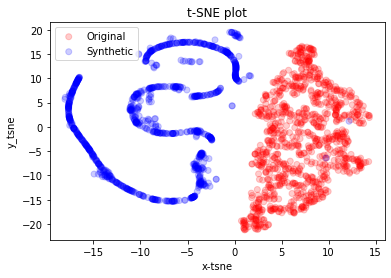

In [146]:
visualization(data, test_recovery.detach().numpy(), 'tsne')

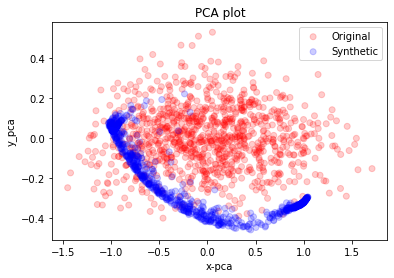

In [141]:
visualization(data, test_recovery.detach().numpy(), 'pca')